In order to run part 1 we need the following libraries:
* open3d
* numpy
In order to run part 2 we need the following libraries:
* vedo
* trimesh
* pymesh
In order to run part 3 we need the following library:
* pyngrok
and in order to run the the GUI we need a token
and in order to stop the GUI run this command in CMD: taskkill /IM ngrok.exe /F



In [60]:
import pymeshlab
import os
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
import seaborn as sns
import vedo
from vtkmodules.vtkFiltersGeneral import vtkDensifyPolyData
from vtkmodules.vtkCommonDataModel import vtkPolyData
from vtkmodules.vtkCommonExecutionModel import vtkAlgorithm
import math
from collections import defaultdict,deque
import itertools
import random
import ast
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
from flask import Flask, render_template, render_template_string, request, jsonify
import plotly.graph_objects as go
from scipy.stats import wasserstein_distance
from pyngrok import ngrok
import io
import plotly # 2goUrmj0CW0NM9UN6m5aChaZGYz_5zazLqJE1PmUxM3szze1Y
from sklearn.preprocessing import MinMaxScaler


# Part 1

In [ ]:

mesh_path = r"./data/ShapeDatabase_INFOMR-master/Door/m1708.obj"


def visualizer(mesh_path):
    # Load the mesh with open3d
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    mesh.compute_vertex_normals()

    # Visualize the mesh
    vis_option = "wireframe_on_shaded"
    if vis_option == "smoothshade":
        o3d.visualization.draw_geometries([mesh], width=1280, height=720)
    elif vis_option == "wireframe_on_shaded":
        # Wireframe atop solid mesh
        # Create a visualizer
        vis = o3d.visualization.Visualizer()
        vis.create_window()

        # Add solid mesh to visualizer
        vis.add_geometry(mesh)

        # Slightly displace the wireframe mesh to avoid z-fighting (mimicking OpenGL offset)
        wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
        wireframe.paint_uniform_color([0, 0, 0])  # Set wireframe color

        # Render solid mesh first, then the wireframe
        vis.add_geometry(wireframe)

        # Get render options and enable hidden surface removal for the wireframe
        opt = vis.get_render_option()
        opt.mesh_show_back_face = True  # Show back faces to ensure wireframe shows fully

        vis.run()
        vis.destroy_window()
    elif vis_option == "wireframe":
        # We first need to obtain a lineset of the wireframe if we don't want to render the mesh itself
        wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
        o3d.visualization.draw_geometries([wireframe], width=1280, height=720)
    elif vis_option == "world_axes":
        # Display the mesh including a world axis system.

        # Create the endpoints of each line. Each line is unit-length.
        # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
        line_endpoints = [
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ]

        # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
        line_indices = [[0, 1], [0, 2], [0, 3]]

        # Create a line set from the endpoints and indices
        world_axes = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(line_endpoints),
            lines=o3d.utility.Vector2iVector(line_indices),
        )

        # Render the line set and the mesh
        o3d.visualization.draw_geometries([mesh, world_axes], width=1280, height=720)
    elif vis_option == "black_background":
        # Create visualizer
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(mesh)

        # Set render options (e.g. background color)
        opt = vis.get_render_option()
        opt.background_color = np.asarray([0, 0, 0])

        # Run the visualizer
        vis.run()
        vis.destroy_window()

In [ ]:
mesh_path = r"./data/ShapeDatabase_INFOMR-master/Door/m1708.obj"

visualizer(mesh_path)

# Part 2

In [ ]:
# Path to the database directory
database_path = "./data/ShapeDatabase_INFOMR-master"

# List to store data for each shape
data = []

def statistics(database_path):
    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)

                    # Load the mesh using PyMeshLab
                    ms = pymeshlab.MeshSet()
                    ms.load_new_mesh(mesh_path)

                    # Get the face data
                    faces = ms.current_mesh().face_matrix()

                    # Determine the types of faces
                    face_types = set()

                    for face in faces:
                        num_vertices_in_face = len(face)
                        if num_vertices_in_face == 3:
                            face_types.add("triangle")
                        elif num_vertices_in_face == 4:
                            face_types.add("quad")
                        else:
                            face_types.add(f"{num_vertices_in_face}-gon")  # Polygon with more vertices

                    # Determine the face type classification
                    if len(face_types) == 1:
                        face_type = f"Only {face_types.pop()}s"
                    else:
                        face_type = ', '.join(face_types)

                    # Calculate the axis-aligned 3D bounding box
                    mesh = o3d.io.read_triangle_mesh(mesh_path)
                    bounding_box = mesh.get_axis_aligned_bounding_box()
                    min_bound = bounding_box.min_bound
                    max_bound = bounding_box.max_bound

                    # Append data to list
                    data.append({
                        'Shape Class': shape_class,
                        'Filename': filename,
                        'Number of Vertices': ms.current_mesh().vertex_number(),
                        'Number of Faces': ms.current_mesh().face_number(),
                        'Face Types': face_type,
                        'Bounding Box Min': min_bound,
                        'Bounding Box Max': max_bound
                    })
    return data

In [ ]:

# Get statistics and create DataFrame
data = statistics(database_path)
df = pd.DataFrame(data)
df.to_csv("./statistics/shape_database_stats.csv",index=False)

In [ ]:
#Retrieve a specific obj from the dataframe
def show_obj_stats(df, obj):
    # Filter the DataFrame for the specified object (filename)
    obj_stats = df[df['Filename'] == obj]

    # Check if the object exists in the DataFrame
    if obj_stats.empty:
        print(f"No object found with the name: {obj}")
    else:
        # Print the statistics of the object
        print(f"Statistics for {obj}:")
        print(obj_stats)

show_obj_stats(df, 'D00626.obj')


In [ ]:
# Load data from CSV
df = pd.read_csv("./statistics/shape_database_stats.csv")

def run_histograms (df):
    # Calculate average number of vertices and faces
    average_vertices = df['Number of Vertices'].mean()
    average_faces = df['Number of Faces'].mean()
    min_vertices = df['Number of Vertices'].min()
    min_faces = df['Number of Faces'].min()
    max_vertices = df['Number of Vertices'].max()
    max_faces = df['Number of Faces'].max()
    # Calculate standard deviation
    std_vertices = df['Number of Vertices'].std()
    std_faces = df['Number of Faces'].std()

    print(f"Average number of vertices: {average_vertices}")
    print(f"Average number of faces: {average_faces}")
    print(f"min number of vertices: {min_vertices}")
    print(f"min number of faces: {min_faces}")
    print(f"max number of vertices: {max_vertices}")
    print(f"max number of faces: {max_faces}")
    print(f"Standard deviation of vertices: {std_vertices}")
    print(f"Standard deviation of faces: {std_faces}")

    # Identify outliers
    vertices_outliers = df[(df['Number of Vertices'] > average_vertices + 2 * std_vertices) |
                          (df['Number of Vertices'] < average_vertices - 2 * std_vertices)]

    faces_outliers = df[(df['Number of Faces'] > average_faces + 2 * std_faces) |
                        (df['Number of Faces'] < average_faces - 2 * std_faces)]

    print("Outliers in vertices count:")
    print(vertices_outliers[['Filename', 'Number of Vertices', 'Shape Class']])
    print("\nOutliers in faces count:")
    print(faces_outliers[['Filename', 'Number of Faces', 'Shape Class']])

    # Filter for shapes with under 100 vertices and/or faces
    small_shapes_df = df[(df['Number of Vertices'] < 100) | (df['Number of Faces'] < 100)]

    # Display the new DataFrame
    print("Shapes with under 100 vertices and/or faces:")
    print(small_shapes_df[['Filename', 'Number of Vertices', 'Number of Faces', 'Shape Class']])


    # Calculate histograms
    vertices_hist, vertices_bins = np.histogram(df['Number of Vertices'], bins=50)
    faces_hist, faces_bins = np.histogram(df['Number of Faces'], bins=50)

    # Convert to DataFrame for easy viewing
    vertices_hist_df = pd.DataFrame({
        'Bin Start': vertices_bins[:-1],
        'Bin End': vertices_bins[1:],
        'Frequency': vertices_hist
    })

    faces_hist_df = pd.DataFrame({
        'Bin Start': faces_bins[:-1],
        'Bin End': faces_bins[1:],
        'Frequency': faces_hist
    })

    print("\nVertices Histogram:")
    print(vertices_hist_df)

    print("\nFaces Histogram:")
    print(faces_hist_df)

    # Plot histograms
    plt.figure(figsize=(60, 50))

    # Histogram of number of vertices
    plt.subplot(2, 2, 1)
    plt.hist(df['Number of Vertices'], bins=50, edgecolor='black')
    plt.axvline(average_vertices, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_vertices:.2f}')
    plt.axvline(average_vertices+std_vertices, color='blue', linestyle='dashed', linewidth=1, label=f'+1 STD: {std_vertices:.2f}')
    plt.axvline(average_vertices + 2 * std_vertices, color='green', linestyle='dashed', linewidth=1, label=f'+2 STD: { 2 * std_vertices:.2f}')
    plt.axvline(average_vertices - std_vertices, color='blue', linestyle='dashed', linewidth=1, label=f'-1 STD: {-std_vertices:.2f}')
    plt.axvline(average_vertices - 2 * std_vertices, color='green', linestyle='dashed', linewidth=1, label=f'-2 STD: { -2 * std_vertices:.2f}')
    plt.title('Histogram of Number of Vertices')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Frequency')
    plt.legend()

    # Histogram of number of faces
    plt.subplot(2, 2, 2)
    plt.hist(df['Number of Faces'], bins=50, edgecolor='black')
    plt.axvline(average_faces, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_faces:.2f}')
    plt.axvline(average_faces + std_faces, color='blue', linestyle='dashed', linewidth=1, label=f'+1 STD: { std_faces:.2f}')
    plt.axvline(average_faces + 2 * std_faces, color='green', linestyle='dashed', linewidth=1, label=f'+2 STD: { 2 * std_faces:.2f}')
    plt.axvline(average_faces - std_faces, color='blue', linestyle='dashed', linewidth=1, label=f'-1 STD: {- std_faces:.2f}')
    plt.axvline(average_faces - 2 * std_faces, color='green', linestyle='dashed', linewidth=1, label=f'-2 STD: {- 2 * std_faces:.2f}')
    plt.title('Histogram of Number of Faces')
    plt.xlabel('Number of Faces')
    plt.ylabel('Frequency')
    plt.legend()

    # Histogram of shape classes
    plt.subplot(2, 2, 3)
    sns.countplot(data=df, x='Shape Class', order=df['Shape Class'].value_counts().index)
    plt.title('Histogram of Shape Classes',fontsize=30)
    plt.xlabel('Shape Class', fontsize=30)
    plt.ylabel('Count',fontsize=30)
    plt.xticks(rotation=45,fontsize=20)

    plt.tight_layout()
    plt.show()


In [ ]:
run_histograms(df)

## Resumpling the meshes

In [2]:

def resample_mesh(mesh_path, target_vertices=10000):
    # Load the mesh using vedo
    mesh = vedo.load(mesh_path)
    prev_mesh=mesh

    # Get the initial number of vertices
    initial_vertex_count = mesh.npoints
    resampled_vertex_count = initial_vertex_count

    # Close holes if there are any
    mesh.fill_holes(size=1)  # Adjust the size of holes to be filled (0.1 means small holes)
    mesh.clean()  # Remove duplicate vertices and degenerate faces
    mesh.triangulate()  # Ensure all faces are triangles for better decimation performance

  #  mesh.clean()
  #  mesh.smooth(niter=1000)  # Apply a smoothing operation with 10 iterations
    mesh.compute_normals()

    if initial_vertex_count > target_vertices:
        # Subsampling: Decimate the mesh to reduce the number of vertices
        mesh = mesh.decimate(fraction=target_vertices/initial_vertex_count)
        resampled_vertex_count = mesh.npoints
        print(f"Subsampling done. Initial vertices: {initial_vertex_count}, Resampled vertices: {resampled_vertex_count}")

    elif initial_vertex_count < target_vertices:

        # Supersampling: Subdivide the mesh until we reach the target vertex count
        iterations = 1
        while mesh.npoints < target_vertices and iterations <= 10:
            mesh = mesh.subdivide(method=4)  # Loop subdivision (method=1)  subdividing as ’centroid’
            iterations += 1
            resampled_vertex_count = mesh.npoints

        # After subdivision, we may overshoot the target, so decimate to exactly match the target
        if mesh.npoints > target_vertices:
            mesh = mesh.decimate(fraction=target_vertices/mesh.npoints)
        if mesh.npoints==0: # if something goes wrong keep the initial shape
            print("here")
            mesh=vedo.load(mesh_path)
            resampled_vertex_count = mesh.npoints
        resampled_vertex_count = mesh.npoints
        print(f"Supersampling done. Initial vertices: {initial_vertex_count}, Resampled vertices: {resampled_vertex_count}")
    #mesh.fill_holes(size=1)
    # Save the resampled mesh
    #mesh.smooth(niter=100)
    mesh.compute_normals()
    resampled_mesh_path = ""
    if "query" not in mesh_path:
      resampled_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master", "ShapeDatabase_INFOMR-master_resumpled")
    else:
      resampled_mesh_path = mesh_path
    

    # Ensure the output directory exists
    output_dir = os.path.dirname(resampled_mesh_path)
    os.makedirs(output_dir, exist_ok=True)
    # Save the mesh in .obj format
    vedo.write(mesh, resampled_mesh_path)
    print(f"Final resampled mesh saved to: {resampled_mesh_path}, Vertices: {resampled_vertex_count}")

    return resampled_mesh_path

## Resampling all the meshes

In [ ]:
def process_all_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
                    resample_mesh(mesh_path)


## Processing the Meshes

In [ ]:
base_path = "./data/ShapeDatabase_INFOMR-master"
process_all_meshes(base_path)

## Run statistics for the resumpled dataset

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_resumpled"
data = statistics(database_path)
df = pd.DataFrame(data)

# Save data to CSV
df.to_csv("./statistics/shape_database_stats_resumple.csv", index=False)

## Run the histogram after sampling

In [ ]:
df= pd.read_csv("./statistics/shape_database_stats_resumple.csv")
run_histograms(df)

# Normalizing the meshes

In [3]:
def ComputePCA(mesh):
    vertices = np.asarray(mesh.vertices)
    cov = np.cov(vertices, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    eigencombined = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
    eigencombined.sort(key=lambda x: x[0], reverse=True)

    eigenvalues = [item[0] for item in eigencombined]
    eigenvectors = [item[1] for item in eigencombined]

    if len(eigenvectors) > 2:
        eigenvectors.pop(2) 
        third_vector = np.cross(eigenvectors[0], eigenvectors[1])
        eigenvectors.append(third_vector / np.linalg.norm(third_vector))  # Normalize the vector

    return eigenvalues, np.array(eigenvectors) 

In [4]:
def align_vertices(vertices,eigenvectors):
    aligned_vertices = np.zeros(vertices.shape)
    for i, p in enumerate(vertices):
        x_updated = np.dot(p, eigenvectors[0])  # Projection onto e1
        y_updated = np.dot(p, eigenvectors[1])  # Projection onto e2
        z_updated = np.dot(p, eigenvectors[2])  # Projection onto e3 (e1 x e2)
        # Store the updated vertex coordinates in the aligned vertices array
        aligned_vertices[i] = np.array([x_updated, y_updated, z_updated])
    return aligned_vertices

In [5]:
def compute_triangle_centroid(vertices, triangle):
    """Helper function to compute the centroid of a triangle."""
    v0 = vertices[triangle[0]]
    v1 = vertices[triangle[1]]
    v2 = vertices[triangle[2]]
    return (v0 + v1 + v2) / 3.0

In [6]:
def flip_mesh_by_volume(mesh):
    # Calculate the flipping values for each axis (x, y, z)
    flipping_values = np.zeros(3)
    
    for face in mesh.cells:
        # Get the vertices of the face (triangle)
        v0, v1, v2 = [np.array(mesh.points()[i]) for i in face]
        
        # Calculate the center of the triangle
        center = (v0 + v1 + v2) / 3
        
        # Add the center coordinates to the flipping values
        flipping_values += center

    # Determine the sign of each flipping value
    flipping_signs = np.sign(flipping_values)

    # Mirror along axes where flipping sign is negative
    for i, axis in enumerate("xyz"):
        if flipping_signs[i] < 0:
            mesh.mirror(axis=axis)

    return mesh  # Return the flipped mesh if needed


In [7]:
def normalize_shape(mesh_path):
    # Load the mesh
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    if mesh.is_empty():
        print(f"Failed to load the mesh: {mesh_path}")
        return None

    # Step 1: Calculate the barycenter and translate the mesh to the origin
    barycenter = np.mean(np.asarray(mesh.vertices), axis=0)
    translated_vertices = np.asarray(mesh.vertices) - barycenter
    mesh.vertices = o3d.utility.Vector3dVector(translated_vertices)
    mesh.compute_vertex_normals()
    
    # Step 2: Align the mesh with principal axes using PCA
    eigenvalues, eigenvectors = ComputePCA(mesh)  # Ensure this function is defined
    aligned_vertices = align_vertices(translated_vertices, eigenvectors)  # Ensure this function is defined
    mesh.vertices = o3d.utility.Vector3dVector(aligned_vertices)
    mesh.compute_vertex_normals()
    
    # Save the translated and aligned mesh
    intermediate_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_resumpled", "ShapeDatabase_INFOMR-master_intermediate")
    os.makedirs(os.path.dirname(intermediate_mesh_path), exist_ok=True)
    o3d.io.write_triangle_mesh(intermediate_mesh_path, mesh)
    
    # Load with Vedo for flipping
    vedo_mesh = vedo.Mesh(intermediate_mesh_path)
    
    # Step 3: Flip mesh along axes if needed
    flipped_mesh = flip_mesh_by_volume(vedo_mesh)  # Ensure this function is updated to use Vedo correctly
    
    # Save the flipped mesh
    flipped_mesh.write(intermediate_mesh_path)  # Save the Vedo mesh

    # Load flipped mesh back into Open3D
    flipped_mesh_o3d = o3d.io.read_triangle_mesh(intermediate_mesh_path)
    flipped_mesh_o3d.compute_vertex_normals()  # Compute normals if necessary

    # Step 4: Scale mesh to fit within a unit cube, centered at the origin
    bounds = flipped_mesh_o3d.get_axis_aligned_bounding_box()
    max_bound = bounds.get_max_bound()
    min_bound = bounds.get_min_bound()
    max_dimension = np.max(max_bound - min_bound)
    scale_factor = 1 / max_dimension  # Scale to fit within the unit cube
    flipped_mesh_o3d.scale(scale_factor, center=[0,0,0])  # Scale around the barycenter

    # Compute normals after scaling
    flipped_mesh_o3d.compute_vertex_normals()
    # Step 5: Save the normalized mesh
    normalized_mesh_path = ""
    if "query" not in mesh_path:
      normalized_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_resumpled", "ShapeDatabase_INFOMR-master_normalized")
    else:
      normalized_mesh_path = mesh_path
    os.makedirs(os.path.dirname(normalized_mesh_path), exist_ok=True)
    o3d.io.write_triangle_mesh(normalized_mesh_path, flipped_mesh_o3d)

    return normalized_mesh_path

## Normalizing all the meshes

In [ ]:
def norm_all_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
                    normalize_shape(mesh_path)

In [ ]:
mesh_path = r"./data/ShapeDatabase_INFOMR-master_resumpled/Door/m1717.obj"
visualize_mesh_with_unit_bbox(mesh_path)
normalize_shape(mesh_path)
mesh_path = r"./data/ShapeDatabase_INFOMR-master_normalized/Door/m1717.obj"
visualize_mesh_with_unit_bbox(mesh_path)
mesh = o3d.io.read_triangle_mesh(mesh_path)
vedo_mesh = vedo.Mesh(mesh_path)
print(verify_translation(mesh),verify_scaling(mesh,mesh_path),verify_alignment(mesh),verify_flipping(vedo_mesh))


## Processing the Meshes

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_resumpled"
norm_all_meshes(database_path)

## Run statistics for the normalized dataset

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data = statistics(database_path)
df = pd.DataFrame(data)
# Save data to CSV
df.to_csv("./statistics/shape_database_stats_norm.csv", index=False)

## Validation

In [ ]:
def verify_translation(mesh, threshold=2e-3):
    # Compute barycenter
    vertices = np.asarray(mesh.vertices)
    barycenter = np.mean(vertices, axis=0)

    # Distance from origin
    distance_to_origin = np.linalg.norm(barycenter)
    return distance_to_origin <= threshold, distance_to_origin

In [ ]:
def verify_scaling(mesh,mesh_path ,margin=1e-4):
    # Get bounding box
    bounding_box = mesh.get_axis_aligned_bounding_box()
    min_bound = bounding_box.get_min_bound()
    max_bound = bounding_box.get_max_bound()

    # Calculate the size along each axis
    bbox_size = max_bound - min_bound
    bbox_x, bbox_y, bbox_z = bbox_size
    max_axis=max(bbox_x, bbox_y, bbox_z)
    if ((bbox_x <= 1+1e-4 and bbox_y <= 1+1e-4 and bbox_z <= 1+1e-4)and(max_axis>=1- 1e-4))==False:
        print("This mesh doesnot fit: ",mesh_path)

    # Check if bounding box fits within unit cube, with a margin
    return ((bbox_x <= 1+1e-4 and bbox_y <= 1+1e-4 and bbox_z <= 1+1e-4)and(max_axis>=1- 1e-4))

In [ ]:
def verify_alignment(mesh, threshold=1e-4):
    vertices = np.asarray(mesh.vertices)
    eigenvalues, eigenvectors = ComputePCA(mesh)
    x_axis = np.array([1, 0, 0])
    y_axis = np.array([0, 1, 0])
    z_axis = np.array([0, 0, 1])
    dot_x = np.abs(np.dot(eigenvectors[0], x_axis))
    dot_y = np.abs(np.dot(eigenvectors[1], y_axis))
    dot_z = np.abs(np.dot(eigenvectors[2], z_axis))
    aligned_x = dot_x >= threshold
    aligned_y = dot_y >= threshold
    aligned_z = dot_z >= threshold
    return aligned_x and aligned_y and aligned_z

In [ ]:
def verify_flipping(mesh):
    # Initialize flipping values for each axis (x, y, z)
    flipping_values = np.zeros(3)
    
    for face in mesh.cells:
        # Get the vertices of the face (triangle)
        v0, v1, v2 = [np.array(mesh.points()[i]) for i in face]
        
        # Calculate the center of the triangle
        center = (v0 + v1 + v2) / 3
        
        # Add the center coordinates to the flipping values
        flipping_values += center

    # Check if all flipping values are positive
    positive_check = np.all(flipping_values >= 0)
    return positive_check

In [ ]:
def analyze_shapes(database_path):
    # Arrays to store results
    translation_results = []
    translation_distances = []
    scaling_results = []
    alingment_results = []
    flipping_results = []

    # Traverse through each shape class directory and process .obj files
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        # Load the mesh
                        mesh = o3d.io.read_triangle_mesh(mesh_path)
                        vedo_mesh = vedo.Mesh(mesh_path)
                        # Verify translation
                        translation_ok, distance_to_origin = verify_translation(mesh)
                        scaling_ok = verify_scaling(mesh,mesh_path)
                        aligning_ok = verify_alignment(mesh)
                        flip_ok = verify_flipping(vedo_mesh)
                        #adding verification for alignment and flipping
                        
                        # Store results
                        translation_results.append(translation_ok)
                        translation_distances.append(distance_to_origin)
                        scaling_results.append(scaling_ok)
                        alingment_results.append(aligning_ok)
                        flipping_results.append(flip_ok)

                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")

    return translation_results, translation_distances, scaling_results,alingment_results,flipping_results

In [ ]:
def plot_histograms(translation_results, translation_distances, scaling_results, alignment_results, flipping_results):
    # Create histograms for translation
    plt.figure(figsize=(12, 6))

    # Histogram for translation (distance to origin)
    plt.subplot(1, 2, 1)
    plt.hist(translation_distances, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(x=2e-3, color='red', linestyle='--', label='Threshold')
    plt.title('Translation Check: Distance to Origin')
    plt.xlabel('Distance to Origin')
    plt.ylabel('Number of Shapes')
    plt.legend()

    # Success/Failure counts for translation
    plt.subplot(1, 2, 2)
    translation_results_numeric = [int(result) for result in translation_results]
    plt.hist(translation_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Translation Result: Barycenter at Origin')
    plt.xlabel('Translation Result')
    plt.ylabel('Number of Shapes')

    # Show the translation plots
    plt.tight_layout()
    plt.show()

    # Create histograms for scaling and alignment
    plt.figure(figsize=(12, 6))

    # Histogram for scaling (fit in unit cube)
    plt.subplot(1, 2, 1)
    scaling_results_numeric = [int(result) for result in scaling_results]
    plt.hist(scaling_results_numeric, bins=2, color='salmon', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Scaling Check: Fits in Unit Cube')
    plt.xlabel('Scaling Result')
    plt.ylabel('Number of Shapes')

    # Success/Failure counts for alignment
    plt.subplot(1, 2, 2)
    alignment_results_numeric = [int(result) for result in alignment_results]
    plt.hist(alignment_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Alignment Result: Align along the XYZ Axis')
    plt.xlabel('Alignment Result')
    plt.ylabel('Number of Shapes')

    # Show the scaling and alignment plots
    plt.tight_layout()
    plt.show()

    # Success/Failure counts for flipping
    plt.figure(figsize=(6, 6))
    flipping_results_numeric = [int(result) for result in flipping_results]
    plt.hist(flipping_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Flipping Result: Flipped Shapes')
    plt.xlabel('Flipping Result')
    plt.ylabel('Number of Shapes')

    # Show the flipping plot
    plt.tight_layout()
    plt.show()

In [ ]:
database_path = "./data/ShapeDatabase_INFOMR-master_normalized"
translation_results, translation_distances, scaling_results,alingment_results,flipping_results = analyze_shapes(database_path)
plot_histograms(translation_results, translation_distances, scaling_results,alingment_results,flipping_results)

In [ ]:
flipping_results.count(False)

## Check the bounding box sizes distribution (Mean and STD) before and after normalization

In [ ]:
def b_box_size(mesh):
    # Get the axis-aligned bounding box
    bounding_box = mesh.get_axis_aligned_bounding_box()
    # Compute the size of the bounding box via its diagonal
    size = np.linalg.norm(bounding_box.get_max_bound() - bounding_box.get_min_bound())
    return size

In [ ]:
def analyze_bounding_box_sizes(database_path):
    # List to store bounding box sizes
    bounding_box_sizes = []

    # Traverse through each shape class directory and process .obj files
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        # Load the mesh
                        mesh = o3d.io.read_triangle_mesh(mesh_path)

                        # Compute the size of the bounding box
                        size = b_box_size(mesh)
                        bounding_box_sizes.append(size)

                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")

    return bounding_box_sizes

In [ ]:
def plot_bounding_box_size_histogram(bounding_box_sizes):
    # Create histogram
    plt.figure(figsize=(8, 6))
    plt.hist(bounding_box_sizes, bins=20, color='lightblue', edgecolor='black')
    plt.title('Bounding Box Size Histogram')
    plt.xlabel('Bounding Box Size (Diagonal Length)')
    plt.ylabel('Number of Shapes')
    plt.axvline(x=np.mean(bounding_box_sizes), color='red', linestyle='--', label='Mean Size')
    plt.axvline(x=math.sqrt(3), color='green', linestyle='--', label='Diagonal of a unit cube')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
database_path = "./data/ShapeDatabase_INFOMR-master_normalized"
bounding_box_sizes = analyze_bounding_box_sizes(database_path)
plot_bounding_box_size_histogram(bounding_box_sizes)

In [ ]:
def calculate_statistics(bounding_box_sizes):
    mean_size = np.mean(bounding_box_sizes)
    std_size = np.std(bounding_box_sizes)
    return mean_size, std_size

In [ ]:
# Calculate and print the mean and standard deviation
mean_size, std_size = calculate_statistics(bounding_box_sizes)
print(f"Mean Bounding Box Size: {mean_size}")
print(f"Standard Deviation of Bounding Box Sizes: {std_size}")

## Check the barycenter distances from its origin distribution (Mean and STD) before and after normalization

In [ ]:
mean_baryC_distance=np.mean(translation_distances)
std_baryC_distance=np.std(translation_distances)
print(f"Mean Barycenter Distance from Origin: {mean_baryC_distance}")
print(f"Standard Deviation of Barycenter Distances: {std_baryC_distance}")

# we need to add opposite orientations

In [ ]:
# def check_opposite_orientations(mesh_path):
#     oppfaces=0
#     not_oppfaces=0
#     print(mesh_path)
#     # Load the mesh
#     mesh = o3d.io.read_triangle_mesh(mesh_path)
#     if mesh.is_empty():
#         print(f"Failed to load the mesh: {mesh_path}")
#         return None

#     # A dictionary to store edges and the corresponding face indices and orientations
#     edges = defaultdict(list)

#     # Traverse each face and store its edges
#     for face_idx, face in enumerate(mesh.triangles):
#         vertex_indices = face.tolist()

#         # Define edges (always store edges with the smaller index first to avoid duplicates)
#         edge1 = (min(vertex_indices[0], vertex_indices[1]), max(vertex_indices[0], vertex_indices[1]))
#         edge2 = (min(vertex_indices[1], vertex_indices[2]), max(vertex_indices[1], vertex_indices[2]))
#         edge3 = (min(vertex_indices[2], vertex_indices[0]), max(vertex_indices[2], vertex_indices[0]))

#         # Store the edges with orientation (True means original order, False means reversed)
#         edges[edge1].append((face_idx, vertex_indices[0] < vertex_indices[1]))
#         edges[edge2].append((face_idx, vertex_indices[1] < vertex_indices[2]))
#         edges[edge3].append((face_idx, vertex_indices[2] < vertex_indices[0]))

#     # Now check for opposite orientations of edges
#     opposite_orientations = []
#     for edge, face_info in edges.items():
#         if len(face_info) == 2:  # The edge is shared by two faces
#             (face1_idx, face1_orientation), (face2_idx, face2_orientation) = face_info
#             if face1_orientation == face2_orientation:  # Same orientation means opposite face orientation
#                 opposite_orientations.append((face1_idx, face2_idx, edge))

#     # Output the result
#     if opposite_orientations:
#        oppfaces=1

#     else:
#         not_oppfaces=1
#     return oppfaces, not_oppfaces

In [ ]:
# # Load or create your mesh
# mesh = o3d.geometry.TriangleMesh.create_sphere()  # Example mesh

# # A dictionary to store edges and the corresponding face indices and orientations
# def fix_mesh_orientation(mesh_path):
#     # Load the mesh
#     mesh = o3d.io.read_triangle_mesh(mesh_path)
#     if mesh.is_empty():
#         print(f"Failed to load the mesh: {mesh_path}")
#         return None
#     # Create a dictionary to store edges and the corresponding face indices and orientations
#     edges = defaultdict(list)

#     # Traverse each face and store its edges
#     for face_idx, face in enumerate(mesh.triangles):
#         vertex_indices = face.tolist()

#         # Define edges (always store edges with the smaller index first to avoid duplicates)
#         edge1 = (min(vertex_indices[0], vertex_indices[1]), max(vertex_indices[0], vertex_indices[1]))
#         edge2 = (min(vertex_indices[1], vertex_indices[2]), max(vertex_indices[1], vertex_indices[2]))
#         edge3 = (min(vertex_indices[2], vertex_indices[0]), max(vertex_indices[2], vertex_indices[0]))

#         # Store the edges with orientation (True means original order, False means reversed)
#         edges[edge1].append((face_idx, vertex_indices[0] < vertex_indices[1]))
#         edges[edge2].append((face_idx, vertex_indices[1] < vertex_indices[2]))
#         edges[edge3].append((face_idx, vertex_indices[2] < vertex_indices[0]))

#     # Mark all faces as unvisited
#     visited = [False] * len(mesh.triangles)

#     def flip_face(face):
#         """Flip the face by reversing its vertices."""
#         return [face[2], face[1], face[0]]

#     def bfs(start_face):
#         """Breadth-first search to fix orientations."""
#         queue = deque([start_face])
#         visited[start_face] = True

#         while queue:
#             face_idx = queue.popleft()
#             current_face = mesh.triangles[face_idx]

#             # Iterate through each edge of the current face
#             for i in range(3):
#                 v0, v1 = current_face[i], current_face[(i + 1) % 3]
#                 edge = (min(v0, v1), max(v0, v1))

#                 # Get all faces sharing this edge
#                 adjacent_faces = edges[edge]

#                 for adj_face_idx, adj_orientation in adjacent_faces:
#                     if adj_face_idx == face_idx or visited[adj_face_idx]:
#                         continue  # Skip the current face or already visited faces

#                     adj_face = mesh.triangles[adj_face_idx]

#                     # Check if orientations are inconsistent
#                     current_orientation = v0 < v1
#                     if current_orientation == adj_orientation:
#                         # Orientations are the same, so flip the adjacent face
#                         mesh.triangles[adj_face_idx] = flip_face(adj_face)

#                     # Mark the adjacent face as visited and add it to the queue
#                     visited[adj_face_idx] = True
#                     queue.append(adj_face_idx)

#     # Find and fix all connected components
#     for face_idx in range(len(mesh.triangles)):
#         if not visited[face_idx]:
#             bfs(face_idx)
#     mesh.compute_vertex_normals()
#     # Save the normalized mesh
#     normalized_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_normalized", "ShapeDatabase_INFOMR-master_normalized_fixedOrientation")
#     os.makedirs(os.path.dirname(normalized_mesh_path), exist_ok=True)
#     o3d.io.write_triangle_mesh(normalized_mesh_path, mesh)

In [ ]:
# def fix_all_meshes(database_path):
#     for shape_class in os.listdir(database_path):
#         shape_class_path = os.path.join(database_path, shape_class)
#         if os.path.isdir(shape_class_path):
#             for filename in os.listdir(shape_class_path):
#                 if filename.endswith(".obj"):  # Check for .obj files
#                     mesh_path = os.path.join(shape_class_path, filename)
#                     print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
#                     fix_mesh_orientation(mesh_path)
# database_path= "C:/Users/panos/Downloads/Multimedia retrival/Labs/ShapeDatabase_INFOMR-master_normalized"
# fix_all_meshes(database_path)

In [ ]:
# def check_orientation_all(database_path):
#     op=0
#     not_op=0
#     for shape_class in os.listdir(database_path):
#         print(shape_class)
#         shape_class_path = os.path.join(database_path, shape_class)
#         if os.path.isdir(shape_class_path):
#             print(shape_class_path)
#             for filename in os.listdir(shape_class_path):
#                 if filename.endswith(".obj"):  # Check for .obj files
#                     mesh_path = os.path.join(shape_class_path, filename)
#                     print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
#                     opp,not_opp=check_opposite_orientations(mesh_path)
#                     op=op+opp
#                     not_op=not_op+not_opp
#     print("oposite faces",op)
#     print("same direction faces",not_op)
#     return op,not_op


# database_path= "C:/Users/panos/Downloads/Multimedia retrival/Labs/ShapeDatabase_INFOMR-master_normalized_fixedOrientation"
# op,not_op=check_orientation_all(database_path)

## visualizing the mehses before and after normalization

In [ ]:
def visualize_mesh_with_unit_bbox(mesh_path):
    # Load the mesh
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    if mesh.is_empty():
        print(f"Failed to load the mesh: {mesh_path}")
        return

    # Step 1: Calculate the barycenter
    barycenter = np.mean(np.asarray(mesh.vertices), axis=0)

    # Compute the bounding box of the mesh
    mesh_bbox = mesh.get_axis_aligned_bounding_box()

    # Set the bounding box color to red (for the actual mesh bounding box)
    mesh_bbox.color = np.array([1, 0, 0])  # Red color

    # Create a unit cube representing the unit bounding box [-0.5, 0.5] in each dimension
    unit_bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=[-0.5, -0.5, -0.5], max_bound=[0.5, 0.5, 0.5])
    unit_bbox.color = np.array([0, 1, 0])  # Green color for the unit cube

    # Create a coordinate frame (axis)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

    # Create a visualization
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # Add the mesh, its bounding box, the unit cube, and the axes to the visualizer
    vis.add_geometry(mesh)
    #vis.add_geometry(mesh_bbox)
    vis.add_geometry(unit_bbox)
    vis.add_geometry(axis)
    # Slightly displace the wireframe mesh to avoid z-fighting (mimicking OpenGL offset)
    wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
    wireframe.paint_uniform_color([0, 0, 0])  # Set wireframe color
    vis.add_geometry(wireframe)

    # Run the visualizer
    vis.run()
    vis.destroy_window()

In [ ]:
mesh_path = "./data/ShapeDatabase_INFOMR-master_normalized/Bus/D00264.obj"
visualize_mesh_with_unit_bbox(mesh_path)

# Part 3.2.1

In [43]:
def compute_obb_volume(mesh):
    # Load the mesh and extract vertex positions
    vertices = np.asarray(mesh.vertices)

 
    eigenvalues, eigenvectors = ComputePCA(mesh)
    eigenvalues = np.array(eigenvalues)
    eigenvectors = np.array(eigenvectors)
   
    # Sort the eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    principal_axes = eigenvectors[:, sorted_indices]
    
    # Calculate the AABB in the new basis
    min_coords = np.min(vertices, axis=0)
    max_coords = np.max(vertices, axis=0)
    
    # Calculate the extents of the OBB
    obb_extents = max_coords - min_coords
    
    # Compute the volume of the OBB
    obb_volume = np.prod(obb_extents)
    
    return obb_volume

In [44]:
def compute_diameter(mesh):

    vertices = np.array(mesh.vertices)
    distances = np.linalg.norm(vertices[:, np.newaxis] - vertices, axis=2)

    return np.max(distances)

In [45]:
def compute_eccentricity(mesh):
        
    eigenvalues, eigenvectors = ComputePCA(mesh)
    eigenvalues = np.array(eigenvalues)
    eigenvectors = np.array(eigenvectors)

    return np.max(eigenvalues)/np.min(eigenvalues)

In [46]:
def compute_all_feature_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
                    normalize_shape(mesh_path)

In [47]:
# List to store data for each shape
def compute_features(database_path):
    data = []
    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    # Append data to list
                    mesh = vedo.load(mesh_path)
                    openmesh = o3d.io.read_triangle_mesh(mesh_path)
                    data.append({
                        "objectID": filename,
                        "area": mesh.area(),
                        "volume":mesh.volume(),
                        "compactness":pow(mesh.area(), 3) / (36 * np.pi * pow(mesh.volume(), 2)),
                        "rectangularity":mesh.volume() / compute_obb_volume(openmesh),
                        "convexity":mesh.volume() / vedo.ConvexHull(mesh).volume(),
                        "diameter":compute_diameter(mesh),
                        "eccentricity":compute_eccentricity(mesh)
                    })
    return data

In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data = compute_features(database_path)
df = pd.DataFrame(data)
# Save data to CSV
df.to_csv("./statistics/shape_database_elementary_attributes.csv", index=False)

In [ ]:

def validate_data(data_path):
    df = pd.read_csv(data_path)
    volume_check_array = df['convexity'] > 1
    return volume_check_array.tolist()


In [ ]:
database_path= "./statistics/shape_database_elementary_attributes.csv"
x = validate_data(database_path)
print(len(x), x.count(True), x.count(False))


# step 3.2.2
In this step we will calculate the descriptors of the shapes:
* a3 - we calculate the angles between 10,000 points.
* d1 - we calculate the distances between the barycenter and |vertices| random points on the mesh
* d2 - we calculate the distance between 10,000 random points
* d3 - we calculate the area of triangle made by three random points (100K)
* d4 - we calculate the volume of tetrahedron made by 4 random points (100K)

In [8]:
def calculate_angle(p1,p2,p3):
    # creating the angle p1p2p3
    vec1 = p1 - p2
    vec2 = p3 - p2
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        cos_theta = 0  # or handle this case as needed
    else:
        cos_theta = np.dot(vec1, vec2) / (norm1 * norm2)
    theta = np.arccos(cos_theta)    
    return np.degrees(theta)

In [9]:
def get_random_points(point_list, number_of_points):
    num_points = len(point_list)
    idx_list = [random.randint(0, num_points-1) for n in range(0,number_of_points)]

    if len(set(idx_list)) < number_of_points:
        return get_random_points(point_list, number_of_points)
    
    return [point_list[a_idx] for a_idx in idx_list]

In [10]:
def a3(mesh):
    # within this function we are calculating the the angle descriptor
    result = []
    points = np.asarray(mesh.vertices)
    sample_size = 10000
    for i in range(sample_size):
        r = get_random_points(points, 3)
        a = calculate_angle(*r)
        result.append(a)
    return result    
    

In [11]:
def calculate_distance(point1, point2):
    # Calculate Euclidean distance between two points in 3D space
    return math.sqrt(sum((p2 - p1) ** 2 for p1, p2 in zip(point1, point2)))    

In [12]:
def d1(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    barycenter = np.mean(vertices, axis=0)
    sample_size = len(vertices)
    for i in range(sample_size):
        idx_p = random.randint(0, sample_size-1)
        result.append(calculate_distance(barycenter, vertices[idx_p]))
    return result

In [13]:
def d2(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 10000
    for _ in range(sample_size):
        result.append(calculate_distance(*get_random_points(vertices, 2)))
    return result

In [14]:
def calculate_triangle_area(p1, p2, p3):
    # Calculate vectors AB and AC
    vec_AB = np.array(p2) - np.array(p1)
    vec_AC = np.array(p3) - np.array(p1)

    # Calculate the cross product
    cross_product = np.cross(vec_AB, vec_AC)

    # Calculate the area (half the magnitude of the cross product)
    area = 0.5 * np.linalg.norm(cross_product)
    return area  # No need for sqrt

In [15]:
def d3(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 10000
    for _ in range(sample_size):
        result.append(calculate_triangle_area(*get_random_points(vertices, 3)))
    return result

In [16]:
def calculate_tetrahedron_volume(point1, point2, point3, point4):
    # Create the matrix from the four points
    matrix = np.array([
        [point1[0], point1[1], point1[2], 1],
        [point2[0], point2[1], point2[2], 1],
        [point3[0], point3[1], point3[2], 1],
        [point4[0], point4[1], point4[2], 1]
    ])

    # Compute the determinant of the matrix
    determinant = np.linalg.det(matrix)

    # Calculate the volume (absolute value of the determinant divided by 6)
    volume = abs(determinant) / 6.0
    return volume

In [17]:
def d4(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 100000
    for _ in range(sample_size):
        result.append(calculate_tetrahedron_volume(*get_random_points(vertices, 4)))
    return result

In [19]:
def compute_descriptors(database_path):
    data = []
    
    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    openmesh = o3d.io.read_triangle_mesh(mesh_path)
                    
                    # Append descriptor data to the list
                    data.append({
                        "objectID": filename,
                        "A3": a3(openmesh),
                        "D1": d1(openmesh),
                        "D2": d2(openmesh),
                        "D3": d3(openmesh),
                        "D4": d4(openmesh),
                    })
                    
    # Convert the list to a DataFrame
    df = pd.DataFrame(data)
    
    # Compute global min-max values and bin the descriptors
    global_min_max = return_global_min_max(df)
    Descriptor_features_df = replace_with_bins(df, global_min_max)
    
    return Descriptor_features_df,global_min_max

In [ ]:
# Assuming rst contains the A3 values
def plot_histogram(a3_values,key ,bins=30):
    plt.hist(a3_values, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(f'{key} Descriptor Histogram')
    plt.xlabel('distance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [24]:

database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data,global_min_max = compute_descriptors(database_path)
df = pd.DataFrame(data)
df_global = pd.DataFrame(global_min_max)
# Save data to CSV
df.to_csv("./statistics/shape_database_descriptors_last_version.csv", index=False)
df_global.to_csv("./statistics/global_min_max_values.csv", index=False)

C:\Users\Ziv\AppData\Local\Temp\ipykernel_24088\1179738482.py:11: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta)


global min_max len: 5
Descriptor_features_df len: 6


PermissionError: [Errno 13] Permission denied: './statistics/shape_database_descriptors_new.csv'

In [26]:
df.to_csv("./statistics/shape_database_descriptors_last_version.csv", index=False)
df.to_csv("./statistics/global_min_max_values.csv", index=False)

In [50]:
df_global.to_csv("./statistics/global_min_max_values.csv", index=False)

In [53]:
df_global

,0,1
0,6.502146e-06,179.999988
1,1.758038e-04,1.020676
2,7.445614e-08,1.528759
3,0.000000e+00,0.648746
4,0.000000e+00,0.184384


In [21]:
def create_histogram(data, gmin, gmax, numOfBins=100):
    # Create histogram bins and counts
    counts, bin_edges = np.histogram(data, bins=numOfBins, range=(gmin, gmax))
    return counts

In [22]:
def return_global_min_max(Descriptor_features_df):
    global_min_max = []  # List to store global min/max for each column

    for column_index in range(1, len(Descriptor_features_df.columns)):  # Iterate through columns after the first one
        all_values = []

        for index in Descriptor_features_df.index:  # Iterate through rows
            value_list = Descriptor_features_df.iloc[index, column_index]

            if isinstance(value_list, list):  # Ensure the value is a list
                all_values.extend(value_list)
            else:
                print(f"Unexpected format in row {index}, column {column_index}: {value_list}")

        if all_values:  # Only calculate min/max if values are present
            global_min = min(all_values)
            global_max = max(all_values)
            global_min_max.append([global_min, global_max])
        else:
            global_min_max.append([None, None])  # Handle empty columns gracefully

    return global_min_max

In [54]:
# def replace_with_bins(Descriptor_features_df, global_min_max):
#     histogram_df = Descriptor_features_df.copy()

#     for column_index in range(1, len(Descriptor_features_df.columns)):
#         for index in Descriptor_features_df.index:
#             value_list = Descriptor_features_df.iloc[index, column_index]

#             if isinstance(value_list, list):  # Ensure the value is a list
#                 histogram = create_histogram(value_list, global_min_max[column_index - 1][0], global_min_max[column_index - 1][1])
                
#                 # Store the histogram in the copy of the DataFrame
#                 histogram_df.iloc[index, column_index] = histogram
#             else:
#                 print(f"Unexpected format in row {index}, column {column_index}: {value_list}")
#                 histogram_df.iloc[index, column_index] = None  # Set to None if value is not a list
#     return histogram_df
# def replace_with_bins(Descriptor_features_df,global_min_max):
#     histogram_df = Descriptor_features_df.copy()
#     print("global min_max len:", len(global_min_max))
#     print("Descriptor_features_df len:", len(Descriptor_features_df.columns))

#     for column_index in range(1, len(Descriptor_features_df.columns)):
#         for index in Descriptor_features_df.index:
#             value_str = Descriptor_features_df.iloc[index, column_index]
#             if isinstance(value_str, str):
#                 value_list = ast.literal_eval(value_str)
#             else:
#                 value_list = value_str
#             histogram = create_histogram(value_list, global_min_max[column_index - 1][0], global_min_max[column_index - 1][1])

#             # Store the histogram in the copy of the DataFrame
#             histogram_df.iloc[index, column_index] = histogram
#     return histogram_df
def replace_with_bins(Descriptor_features_df, global_min_max):
    histogram_df = Descriptor_features_df.copy()
    print("global min_max len:", len(global_min_max))
    print("Descriptor_features_df len:", len(Descriptor_features_df.columns))

    for column_index in range(1, len(Descriptor_features_df.columns)):
        for index in Descriptor_features_df.index:
            # Get the value from the DataFrame cell
            value_str = Descriptor_features_df.iloc[index, column_index]
            
            # If the value is a string, parse it as a list
            if isinstance(value_str, str):
                value_list = ast.literal_eval(value_str)
            else:
                value_list = value_str
            
            # Retrieve the min and max for the current column from global_min_max DataFrame
            min_val = global_min_max.iloc[column_index - 1, 0]
            max_val = global_min_max.iloc[column_index - 1, 1]
            
            # Create the histogram with the correct min and max
            histogram = create_histogram(value_list, min_val, max_val)

            # Store the histogram in the copied DataFrame
            histogram_df.iloc[index, column_index] = histogram

    return histogram_df

In [ ]:
# global_min_max=return_global_min_max(df)

In [ ]:
# Descriptor_features_df = replace_with_bins(df,global_min_max)

In [ ]:
# Descriptor_features_df.to_csv("./statistics/shape_database_descriptors_with_bins1.csv", index=False)

In [135]:

database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
database_stats


,Shape Class,Filename,Number of Vertices,Number of Faces,Face Types,Bounding Box Min,Bounding Box Max
0,AircraftBuoyant,m1337.obj,201,340,Only triangles,[0.025 0.025 0.025],[0.88923401 0.97500002 0.88923401]
1,AircraftBuoyant,m1338.obj,8761,16960,Only triangles,[0.025 0.025 0.025],[0.93305802 0.97500002 0.93790102]
2,AircraftBuoyant,m1339.obj,1878,6173,Only triangles,[0.025 0.025 0.025],[0.607072 0.97500002 0.62681198]
3,AircraftBuoyant,m1340.obj,778,1457,Only triangles,[0.025 0.025 0.025],[0.367686 0.97500002 0.36768901]
4,AircraftBuoyant,m1341.obj,425,824,Only triangles,[0.025 0.025 0.025],[0.37957501 0.97500002 0.37957501]
...,...,...,...,...,...,...,...
2478,WheelChair,D00687.obj,8188,16268,Only triangles,[-0.832973 -0.38382101 -0.446596 ],[0.99701399 0.54519498 0.52508998]
2479,WheelChair,D00720.obj,43966,83378,Only triangles,[-1.25623 -0.51129597 -0.426438 ],[0.625036 0.625521 0.52399403]
2480,WheelChair,D00782.obj,1144,1940,Only triangles,[-1.18256998 -0.42522299 -0.59610301],[0.70089 0.70241803 0.61337 ]
2481,WheelChair,D00821.obj,8188,16268,Only triangles,[-0.82490599 -0.346825 -0.468272 ],[1.00177002 0.52897298 0.50854701]


In [139]:
Descriptor_features_df

,objectID,A3,D1,D2,D3,D4
0,m1337.obj,[ 12 41 61 87 107 122 144 120 169 164 146 1...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[ 5 17 29 46 38 47 63 75 86 111 104 1...,[216 312 388 370 399 372 349 397 323 348 367 3...,[27125 15474 11141 8723 6772 5608 4440 38...
1,m1338.obj,[ 9 25 52 63 71 94 79 97 111 131 127 1...,[ 0 0 0 0 0 0 0 0 0 ...,[ 1 7 15 15 28 36 42 51 44 68 54 ...,[100 154 187 218 262 263 286 279 267 291 275 2...,[16767 12402 10246 8826 7484 6565 5717 50...
2,m1339.obj,[ 76 118 172 184 193 213 203 193 199 243 204 1...,[384 444 332 86 180 191 112 58 34 56 63 2...,[ 85 191 123 155 153 191 223 356 454 548 445 3...,[2025 1844 1384 908 626 561 455 382 291 ...,[85063 8761 3067 1397 746 422 233 1...
3,m1340.obj,[153 175 286 306 330 271 205 174 156 156 141 1...,[ 0 0 0 0 0 0 0 10 13 10 531 9...,[ 133 264 388 445 470 512 611 778 1210 ...,[4390 1231 578 713 725 644 565 392 221 ...,[96096 3345 459 85 13 2 0 ...
4,m1341.obj,[148 308 394 389 376 396 356 314 269 200 174 1...,[ 0 0 0 0 0 0 287 109 78 136 52 ...,[ 45 147 211 320 338 410 467 517 490 406 292 2...,[2637 2033 1698 1214 918 560 337 231 144 ...,[98464 1393 113 20 8 2 0 ...
...,...,...,...,...,...,...
2478,D00687.obj,[ 85 123 151 125 150 130 121 140 156 158 172 1...,[ 0 0 0 0 0 4 5 13 26 46 54 ...,[ 44 66 83 103 83 84 92 95 88 91 120 1...,[775 744 685 592 684 678 646 550 568 571 552 4...,[57207 19201 10634 6193 3389 1713 884 4...
2479,D00720.obj,[ 42 89 107 114 93 121 117 159 132 165 169 1...,[ 0 10 12 16 28 42 27 58 59 98 76 ...,[ 20 41 65 55 71 95 116 115 136 127 168 1...,[581 775 826 795 805 738 697 640 615 545 537 4...,[57976 20513 10642 5642 2793 1305 617 3...
2480,D00782.obj,[167 175 131 85 77 92 99 102 108 139 157 1...,[ 17 65 57 77 76 21 19 20 19 ...,[ 98 259 133 64 37 41 45 43 48 64 64 ...,[1265 584 385 386 391 450 632 685 521 ...,[52339 13703 11015 7087 5621 3222 2667 14...
2481,D00821.obj,[ 87 125 127 119 124 140 153 128 161 136 152 1...,[ 0 0 0 0 0 2 11 29 37 58 48 ...,[ 36 71 80 83 113 90 77 86 81 95 105 1...,[775 773 705 642 613 694 637 606 550 620 546 4...,[56988 19489 10572 6115 3462 1672 922 4...


In [137]:
Descriptor_features_df_for_visual = Descriptor_features_df.merge(
    database_stats[['Filename', 'Shape Class']],  # Select only the relevant columns
    left_on='objectID',                            # Column in Descriptor_features_df
    right_on='Filename',                           # Column in database_stats
    how='left'                                     # Use 'left' to keep all rows in Descriptor_features_df
)

# Rename the "Shape Class" column to "mesh_class" in the merged dataframe
Descriptor_features_df_for_visual = Descriptor_features_df_for_visual.rename(columns={'Shape Class': 'mesh_class'})
Descriptor_features_df_for_visual
# Drop the "filename" column if it’s no longer needed
Descriptor_features_df_for_visual = Descriptor_features_df_for_visual.drop(columns=['Filename'])

AttributeError: 'list' object has no attribute 'asType'

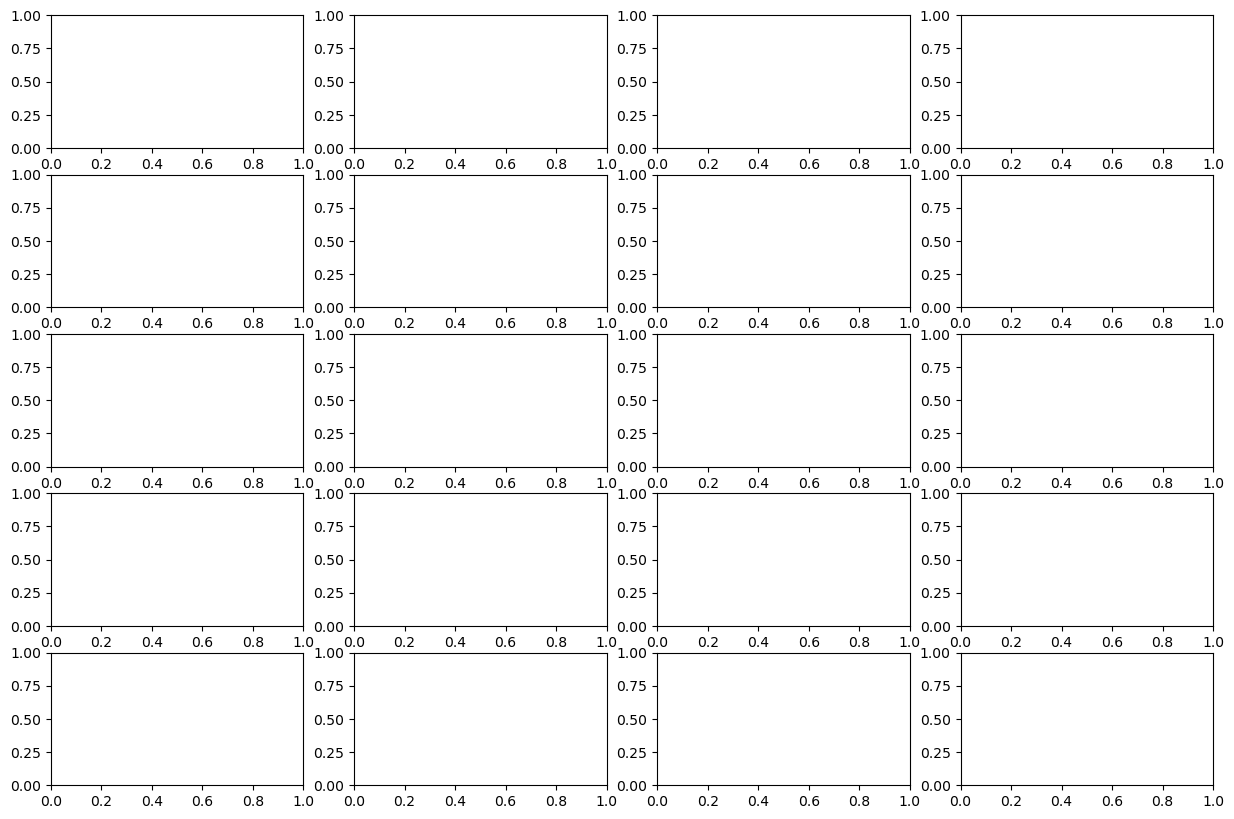

In [156]:
import matplotlib.pyplot as plt

def feature_plotter_df(df):
    # Specify the classes and descriptors
    target_classes = ['jet', 'Humanoid', 'AircraftBuoyant', 'Gun']
    hist_keys = ["A3", "D1", "D2", "D3", "D4"]
    
    # Filter DataFrame for the target classes and take the first 6 elements per class
    filtered_df = df[df['mesh_class'].isin(target_classes)].groupby('mesh_class').head(6)
    
    # Group filtered data by class
    class_groups = filtered_df.groupby("mesh_class")
    
    # Create a figure with subplots for each descriptor
    fig, axes = plt.subplots(len(hist_keys), len(target_classes), figsize=(15, 10))  # 5 descriptors, 4 classes
    
    # Flatten the axes array to easily iterate
    axes = axes.flatten()
    
    # Iterate over each descriptor (A3, D1, D2, etc.)
    for idx, hist_key in enumerate(hist_keys):
        # Create a separate list for each class
        class_histograms = {class_name: [] for class_name in target_classes}
        
        # For each class group, combine histograms for the current descriptor
        for class_name, group in class_groups:
            combined_histogram = []
            
            # Collect histograms for the current class
            for _, row in group.iterrows():
                histogram = row[hist_key]
                if not isinstance(histogram, list):
                    histogram = list(histogram)
                combined_histogram.append(histogram)
            
            # Sum up the histograms (you can modify this if needed)
            combined_histogram = [sum(x) for x in zip(*combined_histogram)]  # Element-wise sum
            
            # Store the combined histogram for this class
            class_histograms[class_name] = combined_histogram
        
        # Plot the combined histograms for each class in the same row for the current descriptor
        for col, class_name in enumerate(target_classes):
            ax = axes[idx * len(target_classes) + col]  # Select the correct subplot
            
            # Plot the combined histogram for the class
            ax.plot(class_histograms[class_name], label=class_name, linewidth=1.5)
            ax.set_title(f"{hist_key}", fontsize=10)
            ax.set_ylim(0, 0.6)  # Adjust y-scale if needed
            ax.tick_params(axis='both', which='both', length=0, labelsize=8)
            ax.legend(loc='upper right', fontsize=8)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Reserve space for suptitle
    plt.suptitle("Combined Histograms for Descriptors by Class", fontsize=14)
    plt.show()

df = Descriptor_features_df_for_visual  # Ensure this dataset is already loaded
feature_plotter_df(df)

# Step 4: Querying

In [27]:
def read_elementary_features(file_path):
    df = pd.read_csv(file_path)
    return df

In [28]:
def Standarize_el_features(el_Features_df):
    # Select the columns you want to normalize (columns 1 and after)
    cols_to_normalize = el_Features_df.columns[1:]

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the selected columns and transform the data
    el_Features_df[cols_to_normalize] = scaler.fit_transform(el_Features_df[cols_to_normalize])
    return el_Features_df

In [29]:
def read_descriptor_features(file_path):
    df = pd.read_csv(file_path)
    return df

In [30]:
def calculate_emd(histogram1, histogram2):
  """
  Calculates the Earth Mover's Distance (EMD) between two histograms.

  Args:
    histogram1: A NumPy array representing the first histogram.
    histogram2: A NumPy array representing the second histogram.

  Returns:
    The EMD between the two histograms.
  """
  emd = wasserstein_distance(histogram1, histogram2)
  return emd

In [31]:
def calculate_emd(features_1, features_2):
    i, j = 0, 1
    flow = [[0 for _ in range(len(features_1))] for _ in range(len(features_1))]
    difference = [0] * len(features_1)
    row = [0] * len(features_1)

    # Initialize empty flow matrix
    for p in range(len(features_1)):
        flow[p] = row.copy()
        flow[p][p] = min(features_1[p], features_2[p])
        difference[p] = features_1[p] - features_2[p]

    # Fill out the flow matrix by spreading differences
    while i + j < 2 * (len(features_1) - 1):
        if difference[i] > 0 and difference[j] < 0:
            if difference[i] <= -difference[j]:
                flow[j][i] = difference[i]
                difference[j] += difference[i]
                difference[i] = 0
                i += 1
                j = i + 1
            else:
                flow[j][i] = -difference[j]
                difference[i] += difference[j]
                difference[j] = 0
                if j < (len(features_1) - 1):
                    j += 1
                else:
                    i += 1
                    j = i + 1
        elif difference[i] < 0 and difference[j] > 0:
            if -difference[i] < difference[j]:
                flow[j][i] = -difference[i]
                difference[j] += difference[i]
                difference[i] = 0
                i += 1
                j = i + 1
            else:
                flow[i][j] = difference[j]
                difference[i] += difference[j]
                difference[j] = 0
                if j < len(features_1) - 1:
                    j += 1
                else:
                    i += 1
                    j = i + 1
        elif difference[i] == difference[j]:
            i += 1
            j = i + 1
        else:
            if j < len(features_1) - 1:
                j += 1
            else:
                i += 1
                j = i + 1

    # Compute sum of distance times flow
    work = 0
    for p in range(len(features_1)):
        for q in range(len(features_1)):
            work += abs(p - q) * flow[p][q]
    
    # 'Normalize' by dividing by total flow
    total_flow = 0
    for i in range(len(features_1)):
        for j in range(len(features_1)):
            total_flow += flow[i][j]
    emd = work / total_flow

    return emd

In [32]:
# def emd_dist_of_descriptors(histogram_norm_df): # query shape will be always in the first row
#     emd_distances = []  # Initialize an empty list to store EMD distances
#     histogram_features_distances=histogram_norm_df.copy()
#     # Iterate through each row of the DataFrame
#     for column_index in range(1, len(histogram_norm_df.columns)):
#       for index in range(histogram_norm_df.shape[0]):
#           if isinstance(histogram_norm_df.iloc[0, column_index], str):
#               Query_hist = np.fromiter(histogram_norm_df.iloc[0, column_index][1:-1].split(), dtype=float)
#           else:
#               Query_hist = histogram_norm_df.iloc[0, column_index]
#           if isinstance(histogram_norm_df.iloc[index, column_index], str):
#               Db_hist = np.fromiter(histogram_norm_df.iloc[index, column_index][1:-1].split(), dtype=float)
#           else:
#               Db_hist = histogram_norm_df.iloc[index, column_index]
#           emd_distance = calculate_emd(Query_hist, Db_hist)
#           histogram_features_distances.iloc[index, column_index] = emd_distance
#     return histogram_features_distances

# def emd_dist_of_descriptors(histogram_norm_df):
#     emd_distances = []  # Initialize an empty list to store EMD distances
#     histogram_features_distances = histogram_norm_df.copy()
    
#     # Iterate through each row of the DataFrame
#     for column_index in range(1, len(histogram_norm_df.columns)):
#         for index in range(histogram_norm_df.shape[0]):
#             if isinstance(histogram_norm_df.iloc[0, column_index], str):
#                 Query_hist = np.fromiter(histogram_norm_df.iloc[0, column_index][1:-1].split(), dtype=float)
#             else:
#                 Query_hist = histogram_norm_df.iloc[0, column_index]
                
#             if isinstance(histogram_norm_df.iloc[index, column_index], str):
#                 Db_hist = np.fromiter(histogram_norm_df.iloc[index, column_index][1:-1].split(), dtype=float)
#             else:
#                 Db_hist = histogram_norm_df.iloc[index, column_index]
                

#             # Check if arrays are equal for self-comparison case
#             if np.array_equal(Query_hist, Db_hist):
#                 emd_distance = 0.0
#             else:
#                 emd_distance = calculate_emd(Query_hist, Db_hist)
            
                
#             histogram_features_distances.iloc[index, column_index] = emd_distance
    
#     return histogram_features_distances
def emd_dist_of_descriptors(histogram_norm_df):
    histogram_features_distances = histogram_norm_df.copy()

    for column_index in range(1, len(histogram_norm_df.columns)):
        for index in range(histogram_norm_df.shape[0]):
            Query_hist = histogram_norm_df.iloc[0, column_index]
            Db_hist = histogram_norm_df.iloc[index, column_index]

            # Convert strings to arrays, if needed
            if isinstance(Query_hist, str):
                Query_hist = np.fromiter(Query_hist[1:-1].split(), dtype=float)
            if isinstance(Db_hist, str):
                Db_hist = np.fromiter(Db_hist[1:-1].split(), dtype=float)

            # Calculate EMD or set to 0 if same
            emd_distance = 0.0 if np.array_equal(Query_hist, Db_hist) else np.abs(calculate_emd(Query_hist, Db_hist))
            histogram_features_distances.iloc[index, column_index] = emd_distance

    
    return histogram_features_distances

In [33]:
# def norm_descriptors_distances(histogram_features_distances):
#     # Select the columns you want to normalize (columns 1 and after)
#     cols_to_normalize = histogram_features_distances.columns[1:]

#     # Create a StandardScaler object
#     scaler = StandardScaler()
#     # Create the histogram_features_distances_stand DataFrame by copying the original
#     histogram_features_distances_stand = histogram_features_distances.copy()

#     # Fit the scaler to the selected columns and transform the data
#     histogram_features_distances_stand[cols_to_normalize] = scaler.fit_transform(histogram_features_distances[cols_to_normalize])
#     return histogram_features_distances_stand
def norm_descriptors_distances(histogram_features_distances):
    cols_to_normalize = histogram_features_distances.columns[1:]

    # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Make a copy and apply standardization to selected columns
    histogram_features_distances_stand = histogram_features_distances.copy()
    histogram_features_distances_stand[cols_to_normalize] = scaler.fit_transform(histogram_features_distances[cols_to_normalize])
    
    return histogram_features_distances_stand

In [34]:
import re
import numpy as np
def area_norm_bins(histogram_df):
    histogram_norm_df = histogram_df.copy()
   # print("ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss")

    for column_index in range(1, len(histogram_norm_df.columns)):
        for index in histogram_norm_df.index:
            value = histogram_df.iloc[index, column_index]

            if isinstance(value, np.ndarray):
                # If it's already a NumPy array, divide by 10000
                array_sum = np.sum(value)


                histogram_norm_df.iloc[index, column_index] = value / array_sum

            elif isinstance(value, str):
                # If it's a string, convert to NumPy array and then divide by 10000
                try:
                    # Remove brackets and split the string
                    value = value.replace("[", "").replace("]", "")
                    value = value.split()
                    # Convert to float array
                    value = np.array(value, dtype=float)
                    array_sum = np.sum(value)
                    # Divide by 10000
                    histogram_norm_df.iloc[index, column_index] = value / array_sum
                except (ValueError, TypeError) as e:
                    print(f"Error converting string to float array: {e}")
                    # Handle the error (e.g., skip this cell, assign a default value)

    return histogram_norm_df

In [35]:
def euclidean_distance(row1, row2):
  """
  Calculates the Euclidean distance between two feature vectors.

  Args:
    row1: A pandas Series representing the first feature vector.
    row2: A pandas Series representing the second feature vector.

  Returns:
    The Euclidean distance between the two vectors.
  """
  features1 = row1.iloc[1:].values  # Select features from column 1 and after
  features2 = row2.iloc[1:].values  # Select features from column 1 and after=
  distance = np.sqrt(np.sum((features1 - features2)**2))
  return distance

In [113]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def calculate_ef_distances(el_features_df, histogram_features_distances_stand):
    ef_distances = []  # Initialize an empty list to store distances
    All_features_dist = histogram_features_distances_stand.copy()

    # Define the query row as the first row
    Query_hist = el_features_df.iloc[0]

    # Calculate Euclidean distances and store in list
    for index in range(el_features_df.shape[0]):
        Db_hist = el_features_df.iloc[index]
        ef_distance = euclidean_distance(Query_hist, Db_hist)
        ef_distances.append(ef_distance)

    # Add calculated distances to the DataFrame
    All_features_dist['elementary_f_dist'] = ef_distances

    # Apply Min-Max normalization to the 'elementary_f_dist' column
    # min_max_scaler = MinMaxScaler()
    # All_features_dist['elementary_f_dist'] = min_max_scaler.fit_transform(All_features_dist[['elementary_f_dist']])

    # Filter for numeric columns only to avoid issues during summation
    numeric_columns = All_features_dist.select_dtypes(include=['number']).columns

    # Calculate and add 'Total_distance' column
    All_features_dist['Total_distance'] = All_features_dist[numeric_columns].sum(axis=1)
    return All_features_dist

In [37]:
def get_shape_class(object_name, df):
    """
    Takes an object name and a CSV file path, and returns the corresponding
    value in the 'Shape Class' column for the given object.
    
    Parameters:
        object_name (str): The name of the object to search for.
        csv_file (str): The path to the CSV file.
        
    Returns:
        str or None: The shape class for the object if found, otherwise None.
    """
    # Search for the object in the DataFrame
    row = df[df['Filename'] == object_name]
    
    # Check if the object was found and return the corresponding 'Shape Class' value
    if not row.empty:
        return row['Shape Class'].values[0]
    else:
        return None

In [38]:
def compute_features_for_query(file_name,mesh_path,database_stats):
    data = []
    mesh = vedo.load(mesh_path)
    openmesh = o3d.io.read_triangle_mesh(mesh_path)
    data.append({
        "objectID": file_name,
        "area": mesh.area(),
        "volume": mesh.volume(),
        "compactness": (mesh.area() ** 3) / (36 * np.pi * (mesh.volume() ** 2)),
        "rectangularity": mesh.volume() / compute_obb_volume(openmesh),
        "convexity": mesh.volume() / vedo.ConvexHull(mesh).volume(),
        "diameter": compute_diameter(mesh),
        "eccentricity": compute_eccentricity(mesh)
    })

    return data

In [39]:
# def compute_descriptors_for_query(file_name,mesh_path,database_stats):
#     data = []
#     openmesh = o3d.io.read_triangle_mesh(mesh_path)
#     data.append({
#         "objectID": file_name,
#         "A3": a3(openmesh),
#         "D1": d1(openmesh),
#         "D2": d2(openmesh),
#         "D3": d3(openmesh),
#         "D4": d4(openmesh),
#     })
#     df = pd.DataFrame(data)
#     global_min_max=return_global_min_max(df)
#     Descriptor_features_df = replace_with_bins(df,global_min_max)
#     return Descriptor_features_df
def compute_descriptors_for_query(file_name, mesh_path, global_min_max):
    data = []
    openmesh = o3d.io.read_triangle_mesh(mesh_path)
    
    # Calculate descriptors for the single object
    data.append({
        "objectID": file_name,
        "A3": a3(openmesh),
        "D1": d1(openmesh),
        "D2": d2(openmesh),
        "D3": d3(openmesh),
        "D4": d4(openmesh),
    })
    
    df = pd.DataFrame(data)
    
    # Use the precomputed global min-max values from the database
    Descriptor_features_df = replace_with_bins(df, global_min_max)
    
    return Descriptor_features_df

In [40]:
def verify_descriptor_data(histogram_norm_df):
    for column_index in range(1, len(histogram_norm_df.columns)):
        for index in range(histogram_norm_df.shape[0]):
            value = histogram_norm_df.iloc[index, column_index]
            # Check if the value is a string representation of an array
            if isinstance(value, str):
                try:
                    parsed_value = np.fromiter(value[1:-1].split(), dtype=float)
                    print(f"Row {index}, Column {column_index} parsed correctly as {parsed_value}")
                except ValueError:
                    print(f"Error parsing Row {index}, Column {column_index}: {value}")
            elif isinstance(value, (np.ndarray, list)):
                print(f"Row {index}, Column {column_index} is already an array: {value}")
            else:
                print(f"Unexpected format at Row {index}, Column {column_index}: {value}")

# GUI To Upload a File

In [160]:

app = Flask(__name__)
UPLOAD_FOLDER = './query'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
NGROK_AUTH_TOKEN = "2goUrmj0CW0NM9UN6m5aChaZGYz_5zazLqJE1PmUxM3szze1Y"  # Replace with your actual authtoken
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

selected_mesh = None

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    global selected_mesh
    if request.method == 'POST':
        # Read features and descriptor files
        el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
        Descriptor_features_df =read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
        database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
        global_min_max = read_descriptor_features("./statistics/global_min_max_values.csv")
        # Handle file upload
        file = request.files['file']
        if file:
            filename = file.filename
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            selected_mesh = filepath
            resample_mesh(filepath)
            normalize_shape(filepath)
            
            # Extract features for the query mesh
            query_features = compute_features_for_query(filename,filepath,database_stats)
            query_hist_features = compute_descriptors_for_query(filename,filepath,global_min_max)

            # Prepare query dataframes
            query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
            query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
            el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
            Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
            el_Features_df.loc[0, 'objectID'] = "query.obj"
            Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
            
            el_Features_df = Standarize_el_features(el_Features_df)
            print("before norm bins:",Descriptor_features_df)
            histogram_norm_df = area_norm_bins(Descriptor_features_df)
            print("after norm bins:",histogram_norm_df)
            histogram_features_distances = emd_dist_of_descriptors(histogram_norm_df)
            print("before:",histogram_features_distances)
            histogram_features_distances_stand = norm_descriptors_distances(histogram_features_distances)
            print("before:",histogram_features_distances_stand)
            #histogram_features_distances_stand = histogram_features_distances_stand.apply(pd.to_numeric, errors='coerce')

            # Get top 5 similar meshes and their distances
            All_features_dist = calculate_ef_distances(el_Features_df, histogram_features_distances_stand)
            print("All features dist unsorted:",All_features_dist)
            All_features_dist=All_features_dist.iloc[1:].sort_values(by=['Total_distance'])
            min_max_scaler = MinMaxScaler()
            All_features_dist['Total_distance'] = min_max_scaler.fit_transform(All_features_dist[['Total_distance']])
           # print(All_features_dist)

            # Get top 5 similar meshes and their distances
            top_5_ids = All_features_dist.iloc[:17, 0].tolist()
            distances = All_features_dist.iloc[:17]['Total_distance'].tolist()
            query_mesh = filepath
            # Paths for original and similar meshes
            mesh_paths = [f"./data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(obj_id, database_stats)}/{obj_id}" for obj_id in top_5_ids]

            # Generate plots
            original_plot = create_mesh_plot(query_mesh)
            similar_plots = [create_mesh_plot(mesh_path, distance) for mesh_path, distance in zip(mesh_paths, distances)]
            if os.path.exists(filepath):
                os.remove(filepath)
            # Render HTML with original and similar objects
            return render_template('mesh_visualization.html', original_plot=original_plot, similar_plots=zip(similar_plots, top_5_ids, distances))

    return render_template('upload.html')

def create_mesh_plot(mesh_path, distance=None):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    plot = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        opacity=1,
        color='blue'
    )])
    plot.update_layout(scene=dict(aspectmode='data'), title=f"Distance: {distance}" if distance else "Original Object")

    # Convert plot to HTML string
    return plot.to_html()


# Expose Flask app with ngrok
public_url = ngrok.connect(5000).public_url
print(f" * Running on {public_url}")

app.run(host='0.0.0.0', port=5000)


 * Running on https://24f0-143-177-169-121.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.81:5000
Press CTRL+C to quit
192.168.1.81 - - [07/Nov/2024 02:41:55] "GET / HTTP/1.1" 200 -


Supersampling done. Initial vertices: 5653, Resampled vertices: 10282
Final resampled mesh saved to: ./query\m166.obj, Vertices: 10282
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
global min_max len: 5
Descriptor_features_df len: 6
before norm bins:         objectID                                                 A3  \
0      query.obj  [146, 235, 274, 239, 259, 247, 295, 262, 249, ...   
1      m1337.obj  [ 12  41  61  87 107 122 144 120 169 164 146 1...   
2      m1338.obj  [  9  25  52  63  71  94  79  97 111 131 127 1...   
3      m1339.obj  [ 76 118 172 184 193 213 203 193 199 243 204 1...   
4      m1340.obj  [153 175 286 306 330 271 205 174 156 156 141 1...   
...          ...                                                ...   
2479  D00687.obj  [ 85 123 151 125 150 130 121 140 156 158 172 1...   
2480  D00720.obj  [ 42  89 107 114  93 121 117 159 132 165 169 1...   
2481  D00782.obj  [167 175 131  85

192.168.1.81 - - [07/Nov/2024 02:43:02] "POST / HTTP/1.1" 200 -


# Step 5: Scalability

In [103]:
from flask import Flask, request, render_template_string
#from flask_ngrok import run_with_ngrok
from sklearn.preprocessing import StandardScaler
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
import scipy as sp
import os
import open3d as o3d
import plotly.graph_objs as go
import scipy as sp


In [98]:
def expand_column(df, col_name):
    # Remove brackets and split values
    expanded = df[col_name].str.strip("[]").str.split(expand=True)
    # Rename columns for uniqueness
    expanded.columns = [f"{col_name}_{i+1}" for i in range(expanded.shape[1])]
    return expanded


In [158]:
app = Flask(__name__)
UPLOAD_FOLDER = './query'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
NGROK_AUTH_TOKEN = "2goUrmj0CW0NM9UN6m5aChaZGYz_5zazLqJE1PmUxM3szze1Y"  # Replace with your actual authtoken
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

selected_mesh = None

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    global selected_mesh
    if request.method == 'POST':
        # Read features and descriptor files
        el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
        Descriptor_features_df =read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
        database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
        global_min_max = read_descriptor_features("./statistics/global_min_max_values.csv")
        # Handle file upload
        file = request.files['file']
        if file:
            filename = file.filename
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            selected_mesh = filepath
            resample_mesh(filepath)
            normalize_shape(filepath)
            
            # Extract features for the query mesh
            query_features = compute_features_for_query(filename,filepath,database_stats)
            query_hist_features = compute_descriptors_for_query(filename,filepath,global_min_max)

            # Prepare query dataframes
            query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
            query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
            el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
            Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
            el_Features_df.loc[0, 'objectID'] = "query.obj"
            Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
            el_Features_df = Standarize_el_features(el_Features_df)
            # Rename 'Filename' to 'objectID' in database_stats for merging
            histogram_norm_df = area_norm_bins(Descriptor_features_df)
            histogram_norm_df.to_csv("./statistics/normhist.csv", index=False)
            histogram_norm_df=pd.read_csv("./statistics/normhist.csv")

            #print("after read csvvvvvvvvvvvvvvvvvvvvvvv",histogram_norm_df)
            

            
            # Apply the function to each of the target columns and concatenate back to the dataframe
            expanded_dfs = [expand_column(histogram_norm_df, col) for col in histogram_norm_df.columns[1:]]  # Skip 'objectID'
            expanded_df = pd.concat([histogram_norm_df[['objectID']]] + expanded_dfs, axis=1)
           # expanded_df.to_csv("C:/Users/panos/Downloads/expanded.csv", index=False)
            

           # histogram_norm_df = pd.concat([histogram_norm_df[['objectID']]] + expanded_dfs, axis=1)
            histogram_norm_df = expanded_df
            print("Expandedddddddddddddddddddddddddddddddddddddddd",histogram_norm_df.head(5))

        

            # Merge the DataFrames
            merged_df = pd.merge(el_Features_df, histogram_norm_df, on='objectID', how='inner')

            
            merged_df = merged_df.drop('objectID', axis=1)
            print("print after dropppppppppppppppppppppppppppppppppppppppppppppppppppppppppp",merged_df)

            feature_total=merged_df.to_numpy()[1:,:]

            # Combine features for KDTree
            

            tree = sp.spatial.KDTree(feature_total)#skip first
            feature_query = merged_df.to_numpy()[0, :]
            
            print(feature_query)
            # Find 6 nearest neighbors (5 most similar + 1 query itself)
            dist, indices = tree.query(feature_query, k=16)

            print("indicessssssssssss:",indices)

            similar_objects=[]
            # similar_objects = el_Features_df.index[indices]

            for i in indices:
               similar_objects.append(el_Features_df.iloc[i,0])

            print("similar objects:",similar_objects)
            # Get top 5 similar meshes and their distances
            top_5_ids = similar_objects
            distances = dist
            query_mesh = filepath
            # Paths for original and similar meshes
            mesh_paths = [f"./data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(obj_id, database_stats)}/{obj_id}" for obj_id in top_5_ids]

            # Generate plots
            original_plot = create_mesh_plot(query_mesh)
            similar_plots = [create_mesh_plot(mesh_path, distance) for mesh_path, distance in zip(mesh_paths, distances)]
            if os.path.exists(filepath):
                os.remove(filepath)
            # Render HTML with original and similar objects
            return render_template('mesh_visualization.html', original_plot=original_plot, similar_plots=zip(similar_plots, top_5_ids, distances))

    return render_template('upload.html')

def create_mesh_plot(mesh_path, distance=None):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    plot = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        opacity=1,
        color='blue'
    )])
    plot.update_layout(scene=dict(aspectmode='data'), title=f"Distance: {distance}" if distance else "Original Object")

    # Convert plot to HTML string
    return plot.to_html()


# Expose Flask app with ngrok
public_url = ngrok.connect(5000).public_url
print(f" * Running on {public_url}")

app.run(host='0.0.0.0', port=5000)


 * Running on https://e908-143-177-169-121.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.81:5000
Press CTRL+C to quit
192.168.1.81 - - [07/Nov/2024 02:39:23] "GET / HTTP/1.1" 200 -


Supersampling done. Initial vertices: 5653, Resampled vertices: 10282
Final resampled mesh saved to: ./query\m166.obj, Vertices: 10282
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
global min_max len: 5
Descriptor_features_df len: 6
Expandedddddddddddddddddddddddddddddddddddddddd     objectID    A3_1    A3_2    A3_3    A3_4    A3_5    A3_6    A3_7    A3_8  \
0  query.obj  0.0141  0.0248  0.0266  0.0236  0.0297  0.0264   0.024   0.023   
1  m1337.obj  0.0012  0.0041  0.0061  0.0087  0.0107  0.0122  0.0144   0.012   
2  m1338.obj  0.0009  0.0025  0.0052  0.0063  0.0071  0.0094  0.0079  0.0097   
3  m1339.obj  0.0076  0.0118  0.0172  0.0184  0.0193  0.0213  0.0203  0.0193   
4  m1340.obj  0.0153  0.0175  0.0286  0.0306   0.033  0.0271  0.0205  0.0174   

     A3_9  ...       D4_91       D4_92       D4_93       D4_94       D4_95  \
0  0.0248  ...  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00   
1  0.0

192.168.1.81 - - [07/Nov/2024 02:39:45] "POST / HTTP/1.1" 200 -
192.168.1.81 - - [07/Nov/2024 02:40:12] "GET / HTTP/1.1" 200 -


Supersampling done. Initial vertices: 5653, Resampled vertices: 10282
Final resampled mesh saved to: ./query\m166.obj, Vertices: 10282
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
global min_max len: 5
Descriptor_features_df len: 6
Expandedddddddddddddddddddddddddddddddddddddddd     objectID    A3_1    A3_2    A3_3    A3_4    A3_5    A3_6    A3_7    A3_8  \
0  query.obj   0.015  0.0231  0.0229  0.0243  0.0226  0.0299  0.0267  0.0258   
1  m1337.obj  0.0012  0.0041  0.0061  0.0087  0.0107  0.0122  0.0144   0.012   
2  m1338.obj  0.0009  0.0025  0.0052  0.0063  0.0071  0.0094  0.0079  0.0097   
3  m1339.obj  0.0076  0.0118  0.0172  0.0184  0.0193  0.0213  0.0203  0.0193   
4  m1340.obj  0.0153  0.0175  0.0286  0.0306   0.033  0.0271  0.0205  0.0174   

     A3_9  ...       D4_91       D4_92       D4_93       D4_94       D4_95  \
0  0.0279  ...  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00   
1  0.0

192.168.1.81 - - [07/Nov/2024 02:40:48] "POST / HTTP/1.1" 200 -


In [ ]:
from flask import Flask, request, render_template_string
#from flask_ngrok import run_with_ngrok
from sklearn.preprocessing import StandardScaler
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
import scipy as sp
import os
import open3d as o3d
import plotly.graph_objs as go

# Sample function to expand columns containing numpy arrays
def expand_column(df, col_name):
    # Remove brackets and split values
    expanded = df[col_name].str.strip("[]").str.split(expand=True)
    # Rename columns for uniqueness
    expanded.columns = [f"{col_name}_{i+1}" for i in range(expanded.shape[1])]
    return expanded





app = Flask(_name_)
UPLOAD_FOLDER = 'C:/Users/panos/Downloads/Multimedia-Retrieval-main/Multimedia-Retrieval-main/query'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
NGROK_AUTH_TOKEN = "2hBtGaSVqa4ffeMqmg5jHIaTYXl_2TLE9V1v7PEhpp1mH2om3"  # Replace with your actual authtoken
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

selected_mesh = None

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    global selected_mesh
    if request.method == 'POST':
        # Read features and descriptor files
        el_Features_df = read_elementary_features(r"C:/Users/panos/Downloads/Multimedia-Retrieval-main/Multimedia-Retrieval-main/statistics/shape_database_elementary_attributes.csv")
        Descriptor_features_df = read_descriptor_features(r"C:/Users/panos/Downloads/Multimedia-Retrieval-main/Multimedia-Retrieval-main/statistics/shape_database_descriptors_with_bins.csv")
        database_stats = read_descriptor_features("C:/Users/panos/Downloads/Multimedia-Retrieval-main/Multimedia-Retrieval-main/statistics/shape_database_stats.csv")

        # Handle file upload
        file = request.files['file']
        if file:
            filename = file.filename
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            selected_mesh = filepath
            resample_mesh(filepath)
            normalize_shape(filepath)
            # filename1=filename
            # filepath1=filepath

            # Extract features for the query mesh
            query_features = compute_features_for_query(filename,filepath,database_stats)
            query_hist_features = compute_descriptors_for_query(filename,filepath,database_stats)

            # ##########dummy
            # # Extract features for the query mesh
            # query_features1 = compute_features_for_query(filename1,filepath1,database_stats)
            # query_hist_features1 = compute_descriptors_for_query(filename1,filepath1,database_stats)

            # Prepare query dataframes
            query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
            query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
            el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
            Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
            
            el_Features_df.loc[0, 'objectID'] = "query.obj"
            Descriptor_features_df.loc[0, 'objectID'] = "query.obj"

            el_Features_df = Standarize_el_features(el_Features_df)
            
            histogram_norm_df = area_norm_bins(Descriptor_features_df)
            histogram_norm_df.to_csv("C:/Users/panos/Downloads/normhist.csv", index=False)
            histogram_norm_df=pd.read_csv("C:/Users/panos/Downloads/normhist.csv")

            #print("after read csvvvvvvvvvvvvvvvvvvvvvvv",histogram_norm_df)
            

            
            # Apply the function to each of the target columns and concatenate back to the dataframe
            expanded_dfs = [expand_column(histogram_norm_df, col) for col in histogram_norm_df.columns[1:]]  # Skip 'objectID'
            expanded_df = pd.concat([histogram_norm_df[['objectID']]] + expanded_dfs, axis=1)
           # expanded_df.to_csv("C:/Users/panos/Downloads/expanded.csv", index=False)
            

           # histogram_norm_df = pd.concat([histogram_norm_df[['objectID']]] + expanded_dfs, axis=1)
            histogram_norm_df = expanded_df
            print("Expandedddddddddddddddddddddddddddddddddddddddd",histogram_norm_df.head(5))

        

            # Merge the DataFrames
            merged_df = pd.merge(el_Features_df, histogram_norm_df, on='objectID', how='inner')

            
            merged_df = merged_df.drop('objectID', axis=1)
            print("print after dropppppppppppppppppppppppppppppppppppppppppppppppppppppppppp",merged_df)

            feature_total=merged_df.to_numpy()[1:,:]

            # Combine features for KDTree
            

            tree = sp.spatial.KDTree(feature_total)#skip first
            feature_query=feature_total[0]


           

            # Find 6 nearest neighbors (5 most similar + 1 query itself)
            dist, indices = tree.query(feature_query, k=6)

            print("indicessssssssssss:",indices)

            similar_objects=[]
            #similar_objects = el_Features_df.index[indices]

            for i in indices:
               similar_objects.append(el_Features_df.iloc[i,0])

            print("similar objects:",similar_objects)


            # Get paths and distances of similar meshes
            top_6_ids = similar_objects
            distances = dist  # Distances returned by KDTree
            print("distancessssssssssssssssssssssssssssss",distances)
            query_mesh = filepath

            # Paths for original and similar meshes
            mesh_paths = [f"C:/Users/panos/Downloads/Multimedia-Retrieval-main/Multimedia-Retrieval-main/data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(obj_id, database_stats)}/{obj_id}" for obj_id in top_6_ids]

            # Generate plots
            original_plot = create_mesh_plot(query_mesh)
            similar_plots = [create_mesh_plot(mesh_path, distance) for mesh_path, distance in zip(mesh_paths, distances)]

            # Render HTML with original and similar objects
            return render_template_string("""
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1.0" />
    <title>Mesh Visualization</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
  </head>
  <body>
    <h1>Top 5 Similar Meshes</h1>
    <div>
      <h2>Original Object</h2>
      <div id="original-plot">{{ original_plot | safe }}</div>
    </div>
    <div>
      <h2>Similar Objects</h2>
      <div>
        {% for plot_html, obj_id, dist in similar_plots %}
        <div>
          <h3>{{ obj_id }}</h3>
          <div id="plot-{{ loop.index }}">{{ plot_html | safe }}</div>
        </div>
        {% endfor %}
      </div>
    </div>
  </body>
</html>
""", original_plot=original_plot, similar_plots=zip(similar_plots, top_6_ids, distances))

    return render_template('upload.html')

def create_mesh_plot(mesh_path, distance=None):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    plot = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        opacity=1,
        color='blue'
    )])
    plot.update_layout(scene=dict(aspectmode='data'),title = f"Distance: {distance}" if distance is not None and distance.any() else "Original Object"

)

    return plot.to_html()

if _name_ == '_main_':
    app.run()

In [65]:
from sklearn.manifold import TSNE
import numpy as np
import csv
import open3d as o3d
from matplotlib import pyplot as plt

In [66]:
def expand_column(df, col_name):
    # Remove brackets and split values
    expanded = df[col_name].str.strip("[]").str.split(expand=True)
    # Rename columns for uniqueness
    expanded.columns = [f"{col_name}_{i+1}" for i in range(expanded.shape[1])]
    return expanded



In [118]:
# Read descriptor, elementary feature, and database stats data
Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_last_version.csv")
el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
database_stats = read_descriptor_features(r"./statistics/shape_database_stats.csv")

# Rename 'Filename' to 'objectID' in database_stats for merging
database_stats = database_stats.rename(columns={'Filename': 'objectID'})

# Expand each target column in Descriptor_features_df and concatenate back to the DataFrame
expanded_dfs = [expand_column(Descriptor_features_df, col) for col in Descriptor_features_df.columns[1:]]  # Skip 'objectID'
expanded_df = pd.concat([Descriptor_features_df[['objectID']]] + expanded_dfs, axis=1)

# Merge expanded_df with el_Features_df on 'objectID' to add columns from el_Features_df
expanded_df = expanded_df.merge(el_Features_df, on='objectID', how='left')

# Merge the Shape Class from database_stats into expanded_df
expanded_df = expanded_df.merge(database_stats[['objectID', 'Shape Class']], on='objectID', how='left')

# Reorder columns to place 'Shape Class' as the second column
cols = ['objectID', 'Shape Class'] + [col for col in expanded_df.columns if col not in ['objectID', 'Shape Class']]
expanded_df = expanded_df[cols]

# Display the first few rows of the final expanded DataFrame
expanded_df.head()

,objectID,Shape Class,A3_1,A3_2,A3_3,A3_4,A3_5,A3_6,A3_7,A3_8,...,D4_98,D4_99,D4_100,area,volume,compactness,rectangularity,convexity,diameter,eccentricity
0,m1337.obj,AircraftBuoyant,12,41,61,87,107,122,144,120,...,0,0,0,2.770102,0.335257,1.672161,0.410810,0.888407,1.020280,2.619286
1,m1338.obj,AircraftBuoyant,9,25,52,63,71,94,79,97,...,0,0,0,3.598979,0.369862,3.013054,0.407566,0.862189,1.046716,1.895304
2,m1339.obj,AircraftBuoyant,76,118,172,184,193,213,203,193,...,0,0,0,2.756522,0.093257,21.294764,0.241328,0.553637,1.000033,5.680690
3,m1340.obj,AircraftBuoyant,153,175,286,306,330,271,205,174,...,0,0,0,0.561354,0.027847,2.017036,0.221579,0.611325,1.000039,26.449918
4,m1341.obj,AircraftBuoyant,148,308,394,389,376,396,356,314,...,0,0,0,0.671116,0.035075,2.172435,0.253718,0.684318,1.000000,34.460033


In [119]:
def get_all_features_for_part_6(df, exclude=None):
    total_features = []
    labels = []
    paths = []

    # Iterate over each row in the DataFrame
    for i, row in df.iterrows():
        object_id = row['objectID']
        label = row['Shape Class']
        
        # Skip if exclude condition is met
        if exclude and object_id == exclude:
            continue
        
        # Extract features by excluding 'objectID' and 'Shape Class' columns
        features = row.drop(['objectID', 'Shape Class']).values
        features = [float(feature) for feature in features if feature != " "]
        
        # Append the label, features, and constructed path
        total_features.append(features)
        labels.append(label)
        paths.append(f"/{label}/{object_id}")
    
    return np.array(total_features), labels, paths

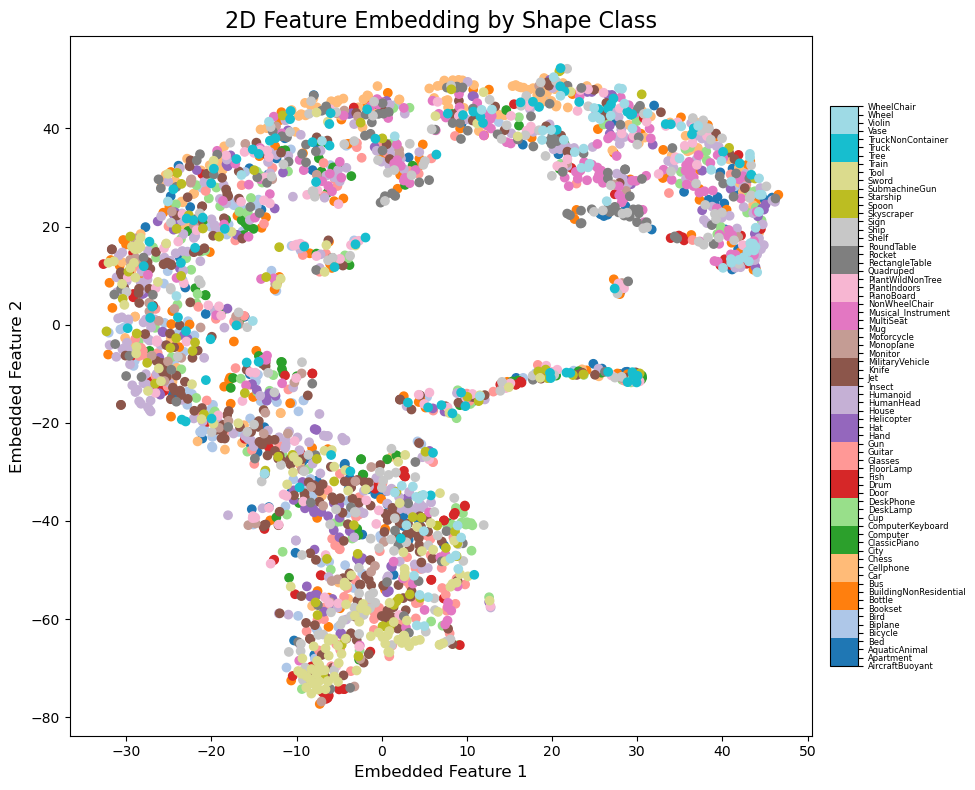

In [124]:
from matplotlib.colors import ListedColormap
# Parameters
tsne_no_components = 2
tsne_perplexity = 35

# Load feature vectors for db shapes
features_total, labels, paths = get_all_features_for_part_6(expanded_df)

tsne = TSNE(
    n_components=2,
    perplexity=35,              # Try values like 5, 10, 50
    learning_rate=10,          # Try values between 10 and 1000 # tried -> 100,200
    n_iter=5000,                # Increase if needed # tried -> 1000,3000
    init='pca',                 # Try 'random' as well
    metric='cosine',         # Try 'cosine' for text/image embeddings
    early_exaggeration=30      # Adjust if needed
)


# Embed feature vectors in lower-dimensional space using T-distributed Stochastic Neighbor Embedding (t-SNE)
features_embedded = tsne.fit_transform(features_total)

# --- Visualize results --- #
# Create a color mapping per class label
colors_map = {}
prev_color = 0
for label in labels:
    if label not in colors_map:
        colors_map[label] = prev_color
        prev_color += 1

# Assign colors based on class labels and create a colormap
num_classes = len(colors_map)
colors = np.array([colors_map[label] for label in labels])
cmap = ListedColormap(plt.colormaps['tab20'].colors[:num_classes])

# Increase figure size for better readability
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(features_embedded[:, 0], features_embedded[:, 1], c=colors, cmap=cmap)

# Title and axis labels
ax.set_title("2D Feature Embedding by Shape Class", fontsize=16)
ax.set_xlabel("Embedded Feature 1", fontsize=12)
ax.set_ylabel("Embedded Feature 2", fontsize=12)

# Create a color bar with the label names
cbar = plt.colorbar(scatter, ticks=np.arange(num_classes), orientation='vertical', shrink=0.8, pad=0.02)
cbar.ax.set_yticklabels(list(colors_map.keys()), fontsize=6, wrap=True)
    

# Display the plot
plt.tight_layout()
plt.show()

Best Parameters: {'perplexity': 5, 'learning_rate': 10, 'early_exaggeration': 12, 'init': 'pca', 'n_iter': 800}
Best Silhouette Score: -0.33568755


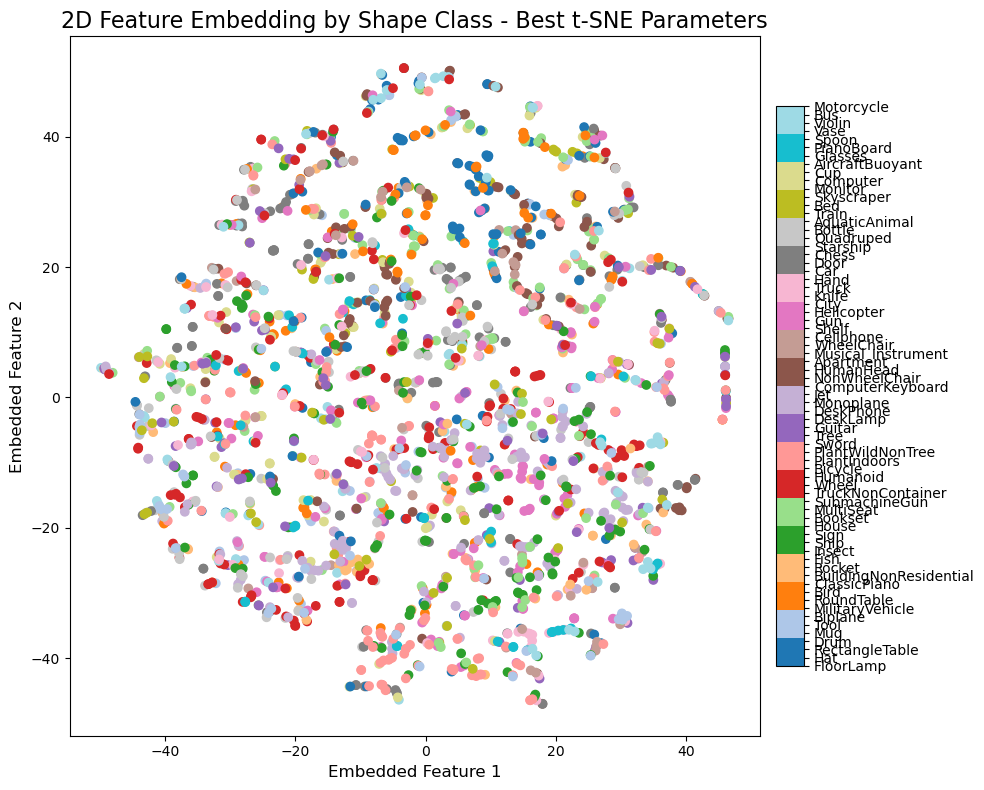

In [127]:
import numpy as np
import itertools
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a grid of parameters to search over
param_grid = {
    'perplexity': [5,10,15,20,30],
    'learning_rate': [10,20,30,50],
    'early_exaggeration': [12],
    'init': ['random', 'pca'],
    'n_iter': [800,1000, 3000,5000]
}

# Function to perform grid search on TSNE parameters
def grid_search_tsne(feature_query, labels, param_grid):
    best_score = -1
    best_params = None
    best_embedding = None
    
    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for params in param_combinations:
        # Initialize TSNE with current parameters
        tsne = TSNE(
            n_components=2,
            perplexity=params['perplexity'],
            learning_rate=params['learning_rate'],
            n_iter=params['n_iter'],
            init=params['init'],
            early_exaggeration=params['early_exaggeration'],
            metric='euclidean'  # Fixed metric for simplicity; could also test 'cosine'
        )
        
        # Fit and transform features
        embedding = tsne.fit_transform(feature_query)
        
        # Calculate silhouette score (assuming `labels` are the shape class labels)
        score = silhouette_score(embedding, labels)
        
        # Update best score and parameters if current is better
        if score > best_score:
            best_score = score
            best_params = params
            best_embedding = embedding
    
    print("Best Parameters:", best_params)
    print("Best Silhouette Score:", best_score)
    return best_embedding, best_params
# Load feature vectors for db shapes
features_total, labels, paths = get_all_features_for_part_6(expanded_df)
# Run grid search
best_embedding, best_params = grid_search_tsne(features_total, labels, param_grid)

# Visualization using best parameters
# Create a color map based on labels
colors_map = {label: i for i, label in enumerate(set(labels))}
colors = np.array([colors_map[label] for label in labels])
cmap = ListedColormap(plt.colormaps['tab20'].colors[:len(colors_map)])

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(best_embedding[:, 0], best_embedding[:, 1], c=colors, cmap=cmap)

# Add title and labels
ax.set_title("2D Feature Embedding by Shape Class - Best t-SNE Parameters", fontsize=16)
ax.set_xlabel("Embedded Feature 1", fontsize=12)
ax.set_ylabel("Embedded Feature 2", fontsize=12)

# Color bar with labels
cbar = plt.colorbar(scatter, ticks=np.arange(len(colors_map)), orientation='vertical', shrink=0.8, pad=0.02)
cbar.ax.set_yticklabels(list(colors_map.keys()), fontsize=10, wrap=True)

plt.tight_layout()
plt.show()

In [ ]:
# Load the meshes with open3d
meshes = []
print("filenames: ")
for i, path in enumerate(paths):
    print(os.path.basename(path), end="    ")
    mesh = o3d.io.read_triangle_mesh(path)
    mesh.compute_vertex_normals()
    mesh.translate([i*1, 0, 0])
    meshes.append(mesh)

# Visualize the mesh
o3d.visualization.draw_geometries(meshes, width=1280, height=720)

# Step 6: Evaluation

In [ ]:
def compute_query_from_step_4(filename, k):
    # Load features and descriptors
    el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
    Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_with_bins.csv")
    database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
    filepath = f"./data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(filename, database_stats)}/{filename}"
    
    # Compute query features and descriptors
    query_features = compute_features_for_query(filename, filepath, database_stats)
    query_hist_features = compute_descriptors_for_query(filename, filepath, database_stats)
    
    # Debugging output
    print("Query Features:", query_features)
    print("Expected number of features:", len(el_Features_df.columns))
    
    # Ensure query_features and query_hist_features are compatible with DataFrame columns
    if not isinstance(query_features, (list, np.ndarray)):
        query_features = [query_features]  # Convert to list if it's a scalar
    
    # If query_features is a single-element list or array, flatten it
    if isinstance(query_features, (list, np.ndarray)) and len(query_features) == 1:
        query_features = query_features[0]  # Get the first element if it's a single-item list
    
    # Verify shapes match the DataFrame columns
    if len(query_features) != len(el_Features_df.columns):
        raise ValueError(f"query_features length {len(query_features)} does not match el_Features_df columns {len(el_Features_df.columns)}")
    
    if len(query_hist_features) != len(Descriptor_features_df.columns):
        raise ValueError(f"query_hist_features length {len(query_hist_features)} does not match Descriptor_features_df columns {len(Descriptor_features_df.columns)}")
    
    # Prepare query dataframes
    query_features_df = pd.DataFrame([query_features], columns=el_Features_df.columns)
    query_hist_features_df = pd.DataFrame([query_hist_features], columns=Descriptor_features_df.columns)
    
    el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
    Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
    
    # Add identifiers for the query
    el_Features_df.loc[0, 'objectID'] = "query.obj"
    Descriptor_features_df.loc[0, 'objectID'] = "query.obj"
    
    # Standardize features and normalize histogram bins
    el_Features_df = Standarize_el_features(el_Features_df)
    histogram_norm_df = area_norm_bins(Descriptor_features_df)
    
    # Compute histogram feature distances and normalize them
    histogram_features_distances = emd_dist_of_descriptors(histogram_norm_df)
    histogram_features_distances_stand = norm_descriptors_distances(histogram_features_distances)
    
    # Calculate distances from query to all items in the database
    All_features_dist = calculate_ef_distances(el_Features_df, histogram_features_distances_stand).iloc[1:].sort_values(by=['Total_distance'])
    
    # Retrieve the top k similar mesh IDs
    top_k_ids = All_features_dist.iloc[:k, 0].tolist()
    return top_k_ids


In [ ]:
import os

def compute_evaluation_data(database_path):
    res = []
    # Read the database statistics once, instead of reading it every time in the loop
    database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")

    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            # Get the number of objects in the current class (for `k`)
            class_files = [f for f in os.listdir(shape_class_path) if f.endswith(".obj")]
            k = len(class_files)

            for filename in class_files:
                # Full path to the mesh file
                mesh_path = os.path.join(shape_class_path, filename)

                # Compute query results with the number of class objects as `k`
                query_results = compute_query_from_step_4(filename, k)

                # Determine class labels for each result
                class_names_of_res = [
                    1 if get_shape_class(result, database_stats) == shape_class else 0
                    for result in query_results
                ]

                # Append the result to the final list
                res.append({
                    "objectID": filename,
                    "evaluated": class_names_of_res
                })

    return res



In [ ]:
evaluation_dataset = "./data/ShapeDatabase_INFOMR-master_normalized/"
evaluation_df = compute_evaluation_data(evaluation_dataset)
evaluation_df.to_csv("./statistics/evaluation_data.csv", index=False)


In [ ]:
res = compute_query_from_step_4("m1337.obj",2)

In [ ]:
# Replace with sample arrays from your actual data
sample_array_1 = np.array([0.1, 0.2, 0.3, 0.4])
sample_array_2 = np.array([0.1, 0.2, 0.3, 0.4])

print("Expected distance (should be 0):", calculate_emd(sample_array_1, sample_array_2))

In [ ]:
Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_with_bins.csv")
Descriptor_features_df

In [128]:
Descriptor_features_df

,objectID,A3,D1,D2,D3,D4
0,m1337.obj,[ 12 41 61 87 107 122 144 120 169 164 146 1...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[ 5 17 29 46 38 47 63 75 86 111 104 1...,[216 312 388 370 399 372 349 397 323 348 367 3...,[27125 15474 11141 8723 6772 5608 4440 38...
1,m1338.obj,[ 9 25 52 63 71 94 79 97 111 131 127 1...,[ 0 0 0 0 0 0 0 0 0 ...,[ 1 7 15 15 28 36 42 51 44 68 54 ...,[100 154 187 218 262 263 286 279 267 291 275 2...,[16767 12402 10246 8826 7484 6565 5717 50...
2,m1339.obj,[ 76 118 172 184 193 213 203 193 199 243 204 1...,[384 444 332 86 180 191 112 58 34 56 63 2...,[ 85 191 123 155 153 191 223 356 454 548 445 3...,[2025 1844 1384 908 626 561 455 382 291 ...,[85063 8761 3067 1397 746 422 233 1...
3,m1340.obj,[153 175 286 306 330 271 205 174 156 156 141 1...,[ 0 0 0 0 0 0 0 10 13 10 531 9...,[ 133 264 388 445 470 512 611 778 1210 ...,[4390 1231 578 713 725 644 565 392 221 ...,[96096 3345 459 85 13 2 0 ...
4,m1341.obj,[148 308 394 389 376 396 356 314 269 200 174 1...,[ 0 0 0 0 0 0 287 109 78 136 52 ...,[ 45 147 211 320 338 410 467 517 490 406 292 2...,[2637 2033 1698 1214 918 560 337 231 144 ...,[98464 1393 113 20 8 2 0 ...
...,...,...,...,...,...,...
2478,D00687.obj,[ 85 123 151 125 150 130 121 140 156 158 172 1...,[ 0 0 0 0 0 4 5 13 26 46 54 ...,[ 44 66 83 103 83 84 92 95 88 91 120 1...,[775 744 685 592 684 678 646 550 568 571 552 4...,[57207 19201 10634 6193 3389 1713 884 4...
2479,D00720.obj,[ 42 89 107 114 93 121 117 159 132 165 169 1...,[ 0 10 12 16 28 42 27 58 59 98 76 ...,[ 20 41 65 55 71 95 116 115 136 127 168 1...,[581 775 826 795 805 738 697 640 615 545 537 4...,[57976 20513 10642 5642 2793 1305 617 3...
2480,D00782.obj,[167 175 131 85 77 92 99 102 108 139 157 1...,[ 17 65 57 77 76 21 19 20 19 ...,[ 98 259 133 64 37 41 45 43 48 64 64 ...,[1265 584 385 386 391 450 632 685 521 ...,[52339 13703 11015 7087 5621 3222 2667 14...
2481,D00821.obj,[ 87 125 127 119 124 140 153 128 161 136 152 1...,[ 0 0 0 0 0 2 11 29 37 58 48 ...,[ 36 71 80 83 113 90 77 86 81 95 105 1...,[775 773 705 642 613 694 637 606 550 620 546 4...,[56988 19489 10572 6115 3462 1672 922 4...


In [ ]:
filepath = "./data/ShapeDatabase_INFOMR-master_normalized/AircraftBuoyant/m1337.obj"
database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
query_hist_features = compute_descriptors_for_query("m1337.obj",filepath,database_stats)
query_hist_features

In [ ]:
def compute_descriptors_for_query(file_name,mesh_path,database_stats):
    data = []
    openmesh = o3d.io.read_triangle_mesh(mesh_path)
    data.append({
        "objectID": file_name,
        "A3": a3(openmesh),
        "D1": d1(openmesh),
        "D2": d2(openmesh),
        "D3": d3(openmesh),
        "D4": d4(openmesh),
    })
    df = pd.DataFrame(data)
    global_min_max=return_global_min_max(df)
    Descriptor_features_df = replace_with_bins(df,global_min_max)
    return Descriptor_features_df

In [ ]:
Descriptor_features_df.iloc[0] =query_hist_features

In [ ]:
Descriptor_features_df

OK, so in order to finalize the normalization we have done 2 more normalization:
alignment and flipping.
we achieve the alignment normalization by following these steps for each object: 
1. computing the PCA (Principal component analysis) of the shape, which we are using the 2 significant eigenvectors can recalculate the third with cross product, to make the direction (inside of the shape and outside) consistance for all meshes
2. compute the projection of these on the x,y and z axis ( by dot product between the eigenvectors and the axis)
3. update the vertices along with the corresponding projections
after doing the aligment we can do now the flipping normalization.
in this normalization we wanted to make sure that all the meshes will have most of their "mass" or "volume" on the positive side of the axis, to stay consistance with all the meshes for better calculation.

we validated that we did the alignemnt correctly by checking if all the meshes are aligned with x,y and z axis, and that most of the mass of the meshes are already in the positive side (there was no need to flip the mesh after flipping it). as we can see here for both the the validation all the meshes have passed their test -> all the meshes in our data is aligned and flipped correctly.


after we finished with the normalization we can start with extracting the features and descriptors of our 3D objects.
these features will be used later in order to compare the objects.

here is an example of calculating the Elementary Descriptors of the Helicopter mesh.
we utilized the vedo and o3d libraries to comute the them
as you can see, the helicopter has an 
1. Area of 0.77 m^2, -> the area of the mesh
2. volume of 0.011 m^3 -> the volume of the mesh
3. Compuctness 32.68 -> how much the mesh look like a sphere.
4. Rectangularity 0.054 -> how much the mesh look like a rectangle.
5. Convexity 0.14 -> if the mesh is flat or curved
6. Diameter 1.04 m -> what is the diameter of the mesh
7. Eccentricity 48.36 -> how stretched is the shape -> alongated -> high -> round -> low 

the descriptors that we calculate for each mesh are:
1. a3 -> which we sampled 10,000 triples of points on the mesh surface and calculate the angle between them.
2. d1 -> which we sampled n points on the mesh surface n = |vertices| and calculated the distance between these points and the barycenter
3. d2 -> which we sampled 10,000 pairs of points on the mesh surface and calculate the distance between them
4. d3 -> which we sampled 10,000 pairs of points on the mesh surface and calculate the tirangle area that these 3 points created
5. d4 -> which we sampled 100,000 quads of points on the mesh surface and calculate the area between them.

after we calculated all of them we binned them and scaled them into 100 bins each.
after doing so for every shape we can continue to the querying step



